In [0]:
%run /Workspace/Users/yesmanki81@gmail.com/Databricks_CV_Anomaly_Detection/Databricks_Code/00_utils

In [0]:
# Check if the mount point exists
mount_path = "/mnt/vision-test"
dbutils.fs.ls(mount_path)

[FileInfo(path='dbfs:/mnt/vision-test/gold_dataset_abnormal/', name='gold_dataset_abnormal/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/gold_dataset_normal/', name='gold_dataset_normal/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images/', name='images/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_dog_final/', name='images_dog_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_final/', name='images_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_noisy_final/', name='images_noisy_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_resized/', name='images_resized/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/labels/', name='labels/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/noisy_images/', name='noisy_images/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/m

In [0]:
# Unmount the directory
# dbutils.fs.unmount(f"/mnt/{mount_name}")

# Process Images

In [0]:
# Convert the list of FileInfo objects to a spark DataFrame
def create_file_into_df(source_dir:str):

    files = dbutils.fs.ls(f"{mount_path}/{source_dir}")

    file_info_list = [
        {
            "path": file.path,
            "name": file.name
        }
        for file in files
        ]

    return spark.createDataFrame(file_info_list)

file_info_df = create_file_into_df("images")
display(file_info_df.limit(2))


name,path
frame_0000.jpg,dbfs:/mnt/vision-test/images/frame_0000.jpg
frame_0001.jpg,dbfs:/mnt/vision-test/images/frame_0001.jpg


In [0]:
# Read the label file
label_files = dbutils.fs.ls(f"{mount_path}/labels")
label_path = label_files[0].path

label_df = spark.read.csv(label_path, header=True, inferSchema=True)
label_df = label_df.withColumnRenamed("image_name", "name")

from pyspark.sql.functions import concat, lit
label_df = label_df.withColumn("name", concat(label_df["name"], lit(".jpg")))
display(label_df.limit(2))

name,label
frame_0000.jpg,dog
frame_0001.jpg,dog


In [0]:
# Join the two DataFrames
file_info_df = file_info_df.join(label_df, on="name", how="left")
display(file_info_df.limit(2))

name,path,label
frame_0000.jpg,dbfs:/mnt/vision-test/images/frame_0000.jpg,dog
frame_0001.jpg,dbfs:/mnt/vision-test/images/frame_0001.jpg,dog


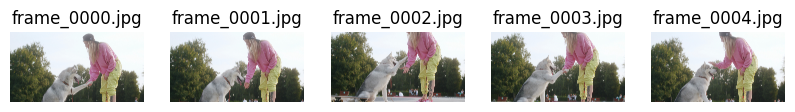

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Spark에서는 분산되어있기 때문에 collect를 사용

def display_image(df, num_images:int=5):
    images = df.take(num_images)
    plt.figure(figsize=(10,10))
    for i, row in enumerate(images):
        img_path = row.path.replace('dbfs:/','/dbfs/')
        img = Image.open(img_path)
        plt.subplot(1,num_images,i+1)
        plt.imshow(img)
        plt.title(row.name)
        plt.axis("off")
    plt.show()

display_image(file_info_df)

Image: frame_0000.jpg, size: 4096 x 2160
img.size = (2160, 2160)
img.size = (256, 256)


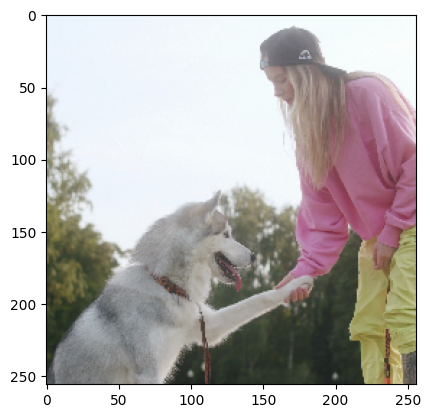

In [0]:
for row in file_info_df.collect():
    img_path = row.path.replace('dbfs:/','/dbfs/')
    img = Image.open(img_path)
    width, height = img.size
    print(f"Image: {row.name}, size: {width} x {height}")
    new_size = min(width, height)

    # Crop 순서: LL, UL, UR, LR
    img = img.crop(((width-new_size)/2, (height-new_size)/2, (width+new_size)/2, (height+new_size)/2))
    print(f"{img.size = }")

    # Resize : 256 x 256
    img = img.resize((256, 256), Image.NEAREST)
    print(f"{img.size = }")
    plt.imshow(img)
    plt.show()
    break

In [0]:
import io
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import BinaryType

IMAGE_SIZE = 256

@pandas_udf(BinaryType())
def resize_image_udf(df_series: pd.Series) -> pd.Series:
    def resize_image(path):
        """Resize image and serialize back as jpeg"""
        # load image
        img_path = path.replace('dbfs:/','/dbfs/')
        img = Image.open(img_path)
        width, height = img.size
        new_size = min(width, height)
        
        # Crop: LL, UL, UR, LR
        img = img.crop(((width-new_size)/2, (height-new_size)/2, (width+new_size)/2, (height+new_size)/2))

        # Resize
        img = img.resize((IMAGE_SIZE,IMAGE_SIZE), Image.NEAREST)

        # Save back to jpg
        output = io.BytesIO()
        img.save(output, format="JPEG")
        return output.getvalue()

    return df_series.apply(resize_image)

# Add the metadata to enable the image preview
image_meta = {
    "spark.contentAnnotation":'{"mimeType": "image/jpeg"}'
}

df = (
    file_info_df.withColumn("image", resize_image_udf("path")).withColumn('image',col('image').alias('image', metadata=image_meta))
    )
display(df.limit(2))

name path label image frame_0000.jpg dbfs:/mnt/vision-test/images/frame_0000.jpg dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABPcUlEQVR4XuS8B1fb17ruy/e4455z9l5ZSRz3AhgDBmPA9N57kQQqCBCSQBISaqj33nuv9GLcHTvFJXGcZqc5iRM7bnRsmtedMjZxjOOVtfY5+45xL+MZ039k2SP65Xnf+bxzkkQ9XHj6T/Vo8R+v0/orml18+ormHq/NPV59RbNLKxvafGX+yXMtLK9taG7lueZX1ze0uLJFa+sL62uvaH6Ltr5nae0v6fH6+iuK2opmq7Zg+i/BeonR2gv9W7DAi+trL+v/a7BeAgSgrG/o34O1tLpFr/PaVm3l8lq9BtaD+fVXtBXWn4B7zmh66emGfme09I/negHrZUYb326SeqbnjDa1yWgrrIXl1aWVyHsWn6wtLa/PzD9+MD338ZVrn31x8+6DR9OLi4urq0Dg026sb4C1Fceb9f8OrD+S+tdgLQJST1bB+vOvv01NnbHbvXqDTaUyaLRmtdZktNpOnjl75979hSfLTwCvlZWN8vz/K6zltYezC6fOXVCoDRKJRiRSsdniDfEFUp5QLJBI7S7Plze/WVxefrz6vJf9t8LaRPNwIaJHC+szi0839McO9Yr+QOq1XIC29qOtsBZW1+ZXQGWt37n/0BMI80VSPl/CZgmZDF4viU7uZVAoTDqN3U/vZ/dz+TyxzeH+4cfbi8uRSnyu9fUNbaUA9GTtmdbXl9efPtP6yvraK/pLsB4t/g5rUy838mda39rON9vTHw3178CaX12bfbL81bc/aAxmNk/IYHIYDE4viUYk9PV0k3FYIhCJ0Ecl0eh9zH4mVyZTnz3/Iehof8VHTzZhrT2HtbL+dHV97RX9y7C2Ft1/E6yVtXvTczqTFXgKkKLR+klEKraLANSF6dkQFtPTHUFGofYxuRzhyOjE0pPfnbWV0b8MayuaP2LaaE+vOmv6VVIRWLNLzwPnK7D+WIa/w9rK6A2wwIu/3HsgU2lZHD6dzuolUfE4UmcHHt3WhUJ2gvWZsEQCDRQmuZdOp/WbzZY7d+4+/mekNmC9qL6nL5Ctrz19rr8E66VevhXWa8rwzbC22morozfBWl6bnlu0OzxisYJKYXTjiJhOfBsKg4C3t7a0wVvRYO1ox2t1dplU10dhkogUqUT65fXrS6trgAWIEVsZvQnW2quk/o/D2jrZPBP4dmUziL6cSN8AC0Sq+YUnXm9IozbQ+pgELLGjrQuJ6GiBoSDNcEAKrH19bDZPwWAK5HINiUjmslhjw4PTCwsgQCz967BW1lY39JdgvcTrr8B6Oru0tqG5x+sv9If+9Udem6b7A6/nAuHzjwIBHYTPgH/IbvbQ+1hdmO52dBcCDgyFgsGQECgCCkMi0ZhODAH4C48l9JEoEp7AqNJ88913iyvLS2urkdAApqK11cdPnwItrYN1PfLwdB3oydOnEa0/13IE36v6lxv8m2C90NactamNTr/htZfa2Wtc9opml1fu3J8eHT7hMLrpvQw8FtfZ3o5sgSNa4DAIrLkZAmtphQNcqLbOtvZOFBqH7qT19KqEkjOnzkzPzc+vgnS6Pr8G0uzKwtrq0j8Ao6eRifLp6uLTtQgv8Mo/nvHaQLbx8EybBvzvhvU6Un8N1srqnQfTAd+gy2g3yeQKLkPST6X34AkdaCaZROnBkbqxYgGXRaMxKX0MYi+tm0jq7Opp6yD3kHlckdsfunjlKtgiHi+vLq+Dklx+vBbRE/AQeV4F+8CmNjaE/2ZYrxmk/01YKxFYM09Wfvr5zvGhkaBJ75bzLMJ+NZvO7sGoOHQ5m8YkdknYNKWQT+3GC+k0RjeejsNROjrxqK7urh4ymUal93M4woA39MsvP9+9e/vmzS9v3Pz6h1s/gB3z4cPpmZm5J09WllfXHq+sgtwPkL1CKgLr/tzaBqDNh60CsDay1cuwZhaeayus36k9jiSsjdLbqq2wNulsPL+8P86trc1E+vTaV59fD9stIa3MxKUp6b0yKtEq4brVEimDxCZijXKxkEbRCfkcQje7G8ft6Sa1YXDIjq52DA6DoxDJLCrDpFIG7LYhr38sMHh8YOLE4NQHJ97/5MKlH7745pcffl6YnV9dXgPUXgNr01BvgBWZb7Y466/AetbsX2X078ECn2B+fXVuZfXB9Mz4wIBdLjVw+jX9NAEBZ5MKBm1GNY/JxHfoxVy9iGOViQSkbj4BJ6dS+MTeHlRbB7y1EwWnk4hMIkHQS1ExuAaONKhxnXCNnw+e+Wj4/Mejpy6OnLh5+fqPX35799YvK08iu+ersAALwOje3Oq9ubX7gNqrmJ7D2tQmr01YW4fEl2E9yxMRvTwt/nNYz9Y/wFpbmVtbmY8kprXZ6dnj4SGDgK+gk9XMPh2bMWw3WRUiRg8GkDJLBQ6lRE4ji3t7dBymnsehYTHdaAQa1sQk4gV9ZElPX0BimjQEztjH3nedPOc4+aH31OXgyWtj7384ePLGB5/c/uLm7W+/n196NiptjJORPPE06uFsxFZ3Z578BngtrN8D7F4l9Xq94rWX8b2K7CVtFuZGbc7/yXS9NWcBza1FtLC6/uTJ6q0bPzj1OrtC4JYKjEyqmdvvN2nY5G6DlG+WCWxKsYpFF5DwJgHHLBaziQRiBxqHaOV092gY/ToSJ8AzBLjGYYnruCZ8Sj98zjh2wTz5sev0J+H3PwpPfX3u4s+fX//5+x+eLC8vrIG08fTxytPllX9E/XJv5s7D+bvTS/fm1+4vPgX6PwrrlcL8l2Bt8JqP9OD133657zGZbDKBnc8x0ajSHnzQoJazqBaFwCjh2JUiLY8hIGHtUr5JJOBTSKSOtm5kKxuP0zH7xWiSicB30ZQehjbANg0JnKc1g6c1wxetUx+6Tl4eOH15+PhPlz+5/eXNez/9sryy9jhyDPsUKOrG9999e+vn+zOPH8yvPQSkIocwr3J5rf5tWC/H+r8Oa+FZrH9uruW1u3ce+O0Os0Rk6Gea6XQlkTBo0BhFbJOUq+UzrDK+lkMTErFmAUvPZbF7cIQ2OBbWzMZ1ael0EaJbjabZiUI3Re4kyf103aTEe1Y7fME0+b554oJj7OPAxFfHz92/fuPGB5fm7z8CeySIxAvrT6MmTo5c/PjD73+6e+/R8sNIp1951ps2cGyOO/94idGrh3+bepXLS/o9eS2tv0xqQ5uM3jDubLwYgbW+Pru8Orv4+JPLVwadTodYYqQxlCTiiBlUJd8i48qZJLuMq+fS5H3d2n6KnstkdKF7EFACAsrq6tD0UYSwLnkr0dzFdhJFVhzf0ysf4VqnZIGPrSfP6UbP6gYvuyY+CU7+8sGVXy5d++L8B8uzCyuroBjXooxWqdvvOH/x0u07c4/mVx/MP364sLqFy/8+WC/NQP8qrIVnsGYArGed69HM7LVLly+MTWjpTCOr/3TI7VSLHAqemIJ1yrlGHk1OwcnIOLADkFEwHKyB3olkoBHaPrK0FatB9GqRFBuWY2xnOnCCMF03JnBd1I+fkg+ckgU/NA5fdo5+Njw589lXN89e/P7KteW5hSdPlqMUmn6bQ//1Nz/cf7QMYD2MwFrbwuW/Dus5r/mXGvx/BRbIqNMLS59//sWPX319YWQkqFefHfYHzEqTiCHtw5kFDBOPJurpkBIx8j4CsbWpq6ma1g6nwqESHEYGx+pRZE0ryYimG1A0G4brIysH+s3nVEMTfN8kz3NB

In [0]:
df.write.mode("overwrite").format('parquet').save(f"{mount_path}/images_resized")

In [0]:
from pyspark.sql.functions import regexp_replace, lit 

@pandas_udf(BinaryType())
def flip_image_horizontally_udf(df_series):
    def flip_image(binary_content):
        """Flip image horizontally and re-serialize back as jpeg"""
        img = Image.open(io.BytesIO(binary_content))
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

        # Save back as jpeg
        output = io.BytesIO()
        img.save(output, format="JPEG")
        return output.getvalue()
    
    return df_series.apply(flip_image)

df_flipped = (
    df.withColumn("image", flip_image_horizontally_udf("image").alias('image', metadata=image_meta))
    .withColumn("name", regexp_replace("name", lit(".jpg"), lit("_flipped.jpg")))
    .withColumn("path", lit("n/a") )
)

display(df_flipped.limit(2))


name path label image frame_0000_flipped.jpg n/a dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABPeElEQVR4XtS8h1eUWZvuzf/xrW++M/N2MqMSRFAUAUFyzqmooqhAESpARSpA5Zxzzokczdradhs62EHtZHeb2kRGSb7fBkwtjKdnzsxZa1zX2uuhqlzL58d1X/u+91PdEc9WVt7R/PLy39Hsyrua2aCNn5lbXplbfFczSy81vbi8rtmFl5p5vrSu6WcvNTW/uK7Xr7yl5am5F+/o6dzKBv1zo57MvvjfKuK/FdbcRi29S+pvwpp5vryuDYD+Z8LaqPnllfmld/WfgzW7sLKu19Q2A/d/Hdb79R5Y4MW5paWX69LSxNzcg8dPv/nu1hdXv348MT0582we3O3qbS/NLaze/0ZYr/Ua1lt6CWudF0CzGbXl6fl/rus1rIn5l9oIayOOt/V4ZuUd/ZfCWlx8Dl5/vnDnwZ8nTp8x2RwanVmrs6jVRoPR7nD4jh8/8/u9B3PAO88WwPqfhgX0Px7Ws6XluYWF72/9aHd7RDK5QCwVCOUcjmRdYrFaKtUq1IaT5y48mpyeW/gfCGtxZfkdLaysLKy8AHq+svJ8eVUbka1Se63X+J4v/vLbHbvDI+BLON28bmY3k8Gh0bqoFBaFzOxi8TlsEV8gFYhl3mDP/UdPZgEXEE8bSM1slmsb2L0kuAmvv+o1tclXejq78mRNr/FtJLU5rKWV5Xe0uEZqFdYaqVVtILWp1yam58+evySXa7q7eMzOrk4yg0zsxONIQB3tVBKxk0JmsFhcVheXwxdpjZYffvp16vnCRlJ/G9Ybi70Oso16O+zX9dewX9e7pP7bYc0/XxwaGuPzxfTOLjKR1o4j4do6sK+EwxKByCQ6g9ENeAkkcr3Z9nBiCpjr/zKszQrzXVL/G1jLL1bWtfCq+taRrdfjRkbv8Hq2vHz//gOLxcZisqmU1aIjERmYJhymCQuERrWCtbWFQMCTKWQ6k8lmc4UKte7uw8dzm2XWRlibUVuFtVlyrTF61btuAmsTc734Oyn2F2e9hPXKUH8TFmgUwAfml5a/u35dJpWRSbROWpdcptfpHS3NhEZ4E6IRA1YkorkJ3dbWSmjHk+g0lkSidDi9E9NzIOn/s7De5fW3YW1Shn8n9d/AWlxeWtd/FBZoqeYWFydmZ4cH+nhsNplEUSi0LJaQw1d20jnQegQgBVZ4AxqFbGlpAtVIYnR2aTVGny88M/scNF/vgTX7lyb+9eizuKZN0Gx85b8S1tre966erwJa04tVzb9YAXr24sUzcLHyYu3ixdzS4tzqTAO6UABr4ceffzaptVK+sJNMI+CIwFOtbUQUpg0GR8FgyIYGFByORiIwzRgstq2d2cl2WDzBQP8TsCkAIhv1yjt/xfTaPpsOhutaWdfU/PJL/UdgbQT0F1ivDbLO5aVeY/rnml6szL1YnnuxBOjMr704uwwa8YXppYXVDmtpcWJ65sypM2qRlNFBwWNaW1GY1qbmZnQTAoVqgDfW10MboDAkHIGCI1qbmwk4PJPCchg9g/3HHzyamHy+uCG5N3HT27W27qDNEn2TPmujNoW1Ec0mAb8R1mplrQX2W1p6trLwHGh54RnQysICoPZ86e7DRxevXPMGwnyemNpB7WhqIbfiGB0kJonSTetkMxgSIY/SjqN14LtA59CCYXa0S7vpSi7LLFe4TQ6/r+fuoydTi0v/IVhv89qg/1uwXvMCdEBaP1tcWlhafv58cXJy+smTCbDT3b79682bN27e+v7Bgzv37v4R9IW5PBGd0U2lMtqxHQQ0ltbSysTjWe0EEYtBbyeoRAIph9FNwio4DDWXyelo03CYVlG3R8EPmQ3j/YO3f7/7dP75Kqy3Juf/YbAAIxDys1Mzd3/949fvfvzywuXPTnx6ou/4eO/ocLCv3xcIOuxmtZpNZ9FIVHwbHtvchke1kJvaeB3tnHY8l9huEAlEDJpJIeGQcDIW2aOR2qQ8OZ2kYlLMPEZYJ+9xWH+4fh38SiYXF6eX38w9rxN9M2pvSG3Uq7c2SajXmpxdWdfbsF41XO+Ses3r0fTy64t3YYF18fnSg9t3f/v+p1tXrl8cPPHF0KnPB86fD5054R4Jad1GrkzN4gnJnV0kIpNMakUhWhCNHWi0AGyCdJqgAy8kt9vkYoOYa5DwuggtGn5Xn91klwmFRLy2m2HkdjsUspHe3scTk9OLS2B/mFla+D+Hta6p+U1a0PfDWtfa9PMuqdeM3jjr+TKouzdT3sz8szs//XLnu1s3P/vqUt/Jr4c/vRw6ecl36pzz5Kfuk2ccw2PGYFBqknZ0ijqpXSQCpgHSjkEycG0GPtfA7ZJQOhRMqlMltciEgBero82mFA84zHoOS9PVqWRSjULBeE//1MTU3BLYSVemlxdnlhffhbV5PW4Ka81Nq7veGqnN9r7XI+FrWH9l9FobSM2+eDSz8nB6+eH0EiAFXolYXPjns8V/zi2DDW75+cLCH7/8+se312+cu/h5z/FrPZ9+4T59wTJ23jR8yjAwru0ZkLqDPFOQb9STuVpWN7ejA49oJLVgOCSiRSI2C7lCMkHNZtpVEotcaJQJONT2gFlr4XWbuugemdChFLoN+ts3f30OvLMESK1qY5M18++cOqyTeovaykY0G320IZ424bJRgNTDVa38Ob30YPL54+mVJ1Mgs5ZezC+9eLa0srC49PD3u3e+v/X7lS+vDIxf7T19yX3you34Ge3AaW1fv9AV5Jh9LJ2boTITBRIMWd/VzSXg21GN5JYmAY1sFgscoNbIOD2f5VCJTVKuVSlUsOkho0bWQTAz6A4B1y4Xes3mP+8+er464iz/e6TeD+utotvER/+FsB7NrerhzPKDifn7T2buPpyMmF0GsFYWF5ZmHj29+dnlR9dvfj9+7nJw5IJz+FPL6AXz2FndwJjUF2DqXWSFl6ZwkEQaDEOMbNcxmVw8FtdQT2xCcDrwBh7bIuSISDgdl2GXC3QCllnGM4k5fUatCviOyTR2dVmk4oDD+eD+Y3Dzr201u9lsuIHUG1hvWvP/TlirvOZWHs+B2Fp+PPnsp9t/3Pzl54i55eXFpeWFqdnvzn929/LXdz+7+mVo7Ip79Kyu75x+6AvbyePy4CDP5qUobHiBiyS2YDmKRpKoAavtpLGxLUQkrAMJY2ExBl6Xrpum6Gw38BgOOU/ZRbbKuQ6lYNCiV5FJJgbTIZH2uVxfXrk6NfdsamFpejWwVrnMbQbr7Qhb19uZ9XKymV/5O43CRlgbJ5vXr7z1Ikj0hScgs54u/PL7g4tfXBo9ORgBcmphevaXq1//ePbi5Dc/fDMwdsU1eMk0cEoeOqXovWgYGRa6e5h6J15oau6y47g6FE2LpMgacbpOKguDZLai8A21VHQDyG85Ba+g4U18hkvBk9BwTiXfpRGfDntM7G4ds+vC8OhXl688nZwCaTW1vDK5srrOrhH5j8J6pf9WWCDUnz2dWbrzYPr8xcuegNNkk0UszS88/OW3b0+cm/j6h5tjZy75ej639l/Q9I3xvaMC/zl1f2+3xU9V2dt4RjTDhGFqG8kGNFWOwEnxbXQEjNGMwEIqSI0QRSdRRmoTd7SY+QyLkCXrxJvFrIBFdXYgEDJoLwwO/vbDjW+//e7p7DzoQv9PYL3RG1jvAvqvgLX8ZBXW8qOnCzd+/NXuNCi13REzd59+f/6Le1e/+f3spWvuoSvWoc+NA2cl/h6i/qKk/4wkFGToHe0iE5pp

In [0]:
df_flipped.write.mode("append").format('parquet').save(f"{mount_path}/images_resized")

In [0]:
new_df = spark.read.format("parquet").load(f"{mount_path}/images_resized")
display(new_df.limit(2))

name path label image frame_0014.jpg dbfs:/mnt/vision-test/images/frame_0014.jpg dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABSbElEQVR4Xuy8h1ebZ9b26//jfO97JokxHSFUkUTvvVdRVEAIod4FEqIIgUCoIKFekASIjrGxHZcUp/c6k14mmXTHheJe5myh2M7EM3kz57zfOt9Z55tc6143khA8P137uvd+zJpDV/bv/ka71+/sXr/9B3Rr78bt/Zt3/oiu3rob1f7tu3t/QNfu3PlXun737v9bOvSA0c7Ve1H9b1j/Sg9h7V77+y/637D+hQ49MNQfdNbOtVtRAayoHkXzO9q7dWf3vh5l9EBXb9+O6n8FRg/0b8N6ILBVVI8S+R39/wvW3o07UT0K4o/o/+Ow9m/v7N8C7V69HdXetVt716O6vX8jogcm+nd99Gv9klm3fvXgrd/qQbQ90DXIr9v3IrrzS5A9eg3X7kV0Fda7d6/evHPj9t2ffr703fc/X7y0+9VX33399TcXLly8eevOrTt34akbsN49WH+lB2/yQPDIzTu/6Nade1Ed2r1664H2rgGp27vXbkYFvKKwfs3rUQp/RL++/kef/acvuw/rgNTvw7obIRWFBTi++/6nzY3jwcCix+W3WZz2WYfP4z+2dfyjjz65fvPWjdt3fkMqCuuXd4joHuj6vXs37/39F929F9WhKCDQ/vU7UYGhos56QOp/cVgPdfvO13/7bmFx2Wn3mI2WGcOMQWec0k5OjU9ZzbOh0MKrr71x89bt67ce4XX/HW4Ao7//PSrY/0b/AOvqjbsRwS/9j/p/DusP6o/AeqCrdyOCDVzqtZu3Lu/snj//vNPlMZstE1rd2PDYqGp4dHBkTD06NqSZ0Iwb9MbNja2Ll6782lwPXAO6DhaDRw489QDfzX8bFgTz/3xS+/8+rP0DWEDqys7u0Y0ts8E8rdePjY6pB1RKuUIplQ9KFSpJv0o2MDSgBmTWmdn33vvz1es3Duj8itSde7fv3rtz9++3bt+9eTsaUndvHWzgS3gKFMmsB7Ae6OqN38KK6L+qoP8W/Vuw9u/DunH79jNPPztrsk6N6bSascEBpUIilfKFUi5fxhXIeWI5XzIgUaj7BzVDGr9v7ocfLwCgW2CW+86Kkrp2/eaVnb2r127cuHkb1r2dvZ3LO5d/vnzl0g5sdq/sHtq9dvdAdw4U2USS60ZEB9Tu/qL7v/3vXNijehTH76N5oIND8L4imP6B1MNch/2dO99+973P7dVrJ8aHR4eUarlYJuGLxFyhkM0XsHhcFk/AEasUw/3SQaVCpdPqNo8e++GnCzdv3/nFVvcirtnb3fvis0/ff/uND0BvvvHOiy+/ff6VD155+5M3//zFnz/52ydffvnhZ/+kz9q7dueRwvwnF//oFT6qRwH9wXf4jYkeJXWge5FHbt06e+7cjMEwNqQeUSn7JQoRV8Tv4/FYXA6TzWL0MZkcnc40qbPotMZ+ycCwcnBCq11fXb92Dc6DO7cixXgX9q+++OLpYxsn1xaeWg8/vbr07PL6S2tnXz/+3HvnXv34pfe/evfz7z74+vdgPdT1B43o3Qd69Ar/qR7W0YGu/jFvPsroUVhRu13c2XG73XqdDmCp+xXgKW4vh9Xdy+zq6aF1d1O6uroYatWoeXrW7wqqZEqFSDg6OGia0s95vaFgIBgMeP1et9NpmZ4O2K1L7tllh2XNbjvtDz87f+q5xTPnw2deWH36je2Xvnzlk38Ca/dfw9q78d8G69FX/sN3PcLoUV4RWLfvXNnbnwsEpibGx9TqAalYxONzelnMru5uKq2LQgXRKJRh5ZCYK+6j97Jp3Xxmt4LPlXE5AyKBXMiTifhSMV8m4CmFAp1KYRkd9E5ow9OmLatnezZ42hU+H9x8fuHYi+HtNzfPHXpws+EhrEgf/7BHjcLavX43qr0b9w70X5TYHyHyEM0/Aj2I898CelTXD2BBH/D2229bTMbJMY1SJhZyuZze3h46vZtKpba3U9rIVHJrV1sHo50qZPYpgBGvDyRhdgu6aXwGnddD6+vqFPZ2S5iMfhZjXMSzq9X+4fF5zfTyhGF9amZl3LCinT5pdr40t/TPnPUorEjwR5ne+0URav8wBv3TxuJRLv9UvyX1x2BdvRWZHOFEu3T5ksfpsM/MDCqkQi6H08vsoYOtOoFUJ7m1u50s53KHJPJBoXhMLlXxegc5zGE+W8FiSJg0flcHq7NFxKQLaJ1iWscQi6Hj8GaE/Rb+oFsyFhyYWh4yb47ZtidcZ6b9D+9nXbl6L6qdq3cezIn3T8l7v3HfDjx4/xbNI/dqHpjut1D+lX5L6o/BivACf92+fev27TmP12aeGYF857D4zC42ndLT2cbt7ZIJ2AoOSyOXWcbHRySSSWX/mFSg7Ose4vXq5MJhIVvSQxXS20EDfQxuS6OkpW2E2qtniL2SySW1+/h48PjY3Mag69RY8Lxx7dClq3d/o0dvND/qvp2rd38zUe5FhspIwR60HQe59kvn8U/6tX+lfwvWwz7r1p2nzj4NfZZJO66TCXUSvk7MH2QzBjiMqWG5Xi4dFfCMI2rj2PCEUmHVjqrY3co+unFQqh8QKXqp8p5OIbVZJ+KqOuhTdJGbM7o6YFlXOzZGfZvDzgWRLsAdXZRMndYFDl3cvxPVfwOs+3voOa7dvBfpPH5D6r8V1oMO/vqt2z/88NNbr78VdLgD+kmPZtQ+qJyWi0aELOe0xjsxphXzh8U8x/TEjHbYo58AWCp2F8CyaweH+cz+XqqY3mpSiCd7uSaGzNo1EODrVgasyypHWGYMcEaC3JEAV7Ohmj30897tqB7AuvxHYf022nZ2r124uLO3f/PiJeiDb129FpnAfwvrd3n934MVuW1w8xbMMO++/uaqzRHUTdmUKoNEpBGwHBPqTeesSaUYErDNWrVLrw2YpzTCPhWLbhgQO7TqCQlX3t0h62qbFHIsQtkMQ+5gDM7SlT7OeFBkCPEnvD1KX8+Av1e92W9+6KwHegDrEUAPdWU/0l7s7N+MwoJ1Z//GN99++9HHH3/517++9/77P/z4w/7Vq5d3r+5eu3ntVmQUfwDrj8T/o2ge1dX7m+uR5Lpz7fbtq1evv/7s8yfmF2fVQ3qRYELANg2IVi3G4PTEsLDPYxj3GyfCs0YANNjXpVcI3RPDsAdwMjp5UsCxCmQz3fIAR+vsGpylDvjY2rm+EQ9d6qaKvV2KNan+98rwUUYPBIPRpZ1rP13chfXny/s//rzz6Rdfnz174qmnT54+c/zpZ5586eVnvvr6048+/fRv3/90cWf/187674L1Dzq4e7d/+zaU5P6VnWePbllV/XalbFYhnFGIN13WaaU4MDNp16pDpkm9XNDP6JwZlDk0qgkxR9VLk9PJRjHfypOaaOIQb2KeOwG83IyhOaba1SF0tfFcnaIVvvYhrMvX7kV15T6vRxn9Cta9H3/efffPH33yxVevvvEObP7y0aeLS97wsmfjaOjoVmjzaPDY9uILLz3//gcfff7VN/8znPVrUjs3b/y4u/Pj/t7FW7ev3rjx6XvvOUaGbXLJrJg7LWCv24wu3dC8bdo2pvJPaWbVikEmzaKUOkaU5gFJf1dHP71Nz2NbuZKJlr4QR7sqNjioSgdtYI6hdLZyrQ09DjJvmTv2q9bhvi79ymsPCP5GVwDWxZ3F1XBw0eX2WY4d33znnXe3t9cDAdv8/KzXPbG0aFpa0J87t3buqRMff/zJ

In [0]:
noisy_df = create_file_into_df("noisy_images")
noisy_df = noisy_df.withColumn('label', lit('noisy'))
resized_noisy_df = (
    noisy_df.withColumn("image", resize_image_udf("path"))
            .withColumn('image',col('image').alias('image', metadata=image_meta))
)
display(resized_noisy_df.limit(2))

name path label image frame_0000_noisy.jpg dbfs:/mnt/vision-test/noisy_images/frame_0000_noisy.jpg noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABRF0lEQVR4XuS7B3BbZ5quybE73Z3Z3XtrprZuzUzN9NzudlSiAilKTKIoikGMYs4BAJGYAAIkMggGACQikXPOiTmJypasYFuy5KBgy7KVLIlizsn7g5QpWVS7PV09u1W7qrdOHR3ApPD4/b7//f5zEPBsevUvanTmh1c0NvPD+PTKK5qYWV3X5OwPzzW3PDm39FMtTswurAucr2tqfmld0wvLr2hmceXPanllemX5FU1t0ub3zK6szK1pdnl5s9Zfeq0CNqPZrL8pLD+vVxj9lbCWVmZWll/W/wdhbUaz+covgTW7tEmv89pm/fWwRqZW1vV0chkcN5P6i7DW6YDjxvlmWFPzyz/q9VD+IpoNrb1t7c1A88tjk7MjY1OXPv702he3Hj19NjYzM7O0NL20CD72zPISOL4G1i/g8lr9vwALFOBmTL8cFhD4IYDXvYePjw2fNpudKrVRIlXL5Fq5UqvWG4+fOv3wydPp+YW5JfADl9bL8/+3sJZHJqaOnzknkWv4fCmXK2GxBEwmD6iN097K47fx+Gab44tbt2cXFmf/i2Bt6DWwpgGaV7XRoX7aqlYn5lbH51bG55f9mvWvfa/08l/CaHrpJ5paWplcBsfluaWVx0+eOd0drTwhm8NntnCaGtlkUgOFzABqZDCbGpqYzWxOG99ksd+5ew+U6ot+BJrUmjZTAJpfXtPKysLK6ppWFleWX9ELWJsZbWhsevUlRht6FdbU7ArQ5NzKxPzS+PzS2MLS+NzziPAzpF4La2oN0MuaWFqeWFi49fVdhULLYnMbmlgAC5XCIJPo9XVkXC0BjyMS6yk0Ip1Ba2puYguF0tNnL0zOzP8SH81vwFp+DmtxZXVpZfkVvYC1UWJ/BtaLilvXJlgr07NLU0BrdbfOa2JTRNhM6pfDejw+qdGZuBxhUxOLzmghkGi12Hospm5DtZi6OoCMQKVRG9ksbm/f4My8v9P/zWCt4xideRXQjwIQV0anlyZmlsamF4EmgXdmlydmf9Kt1mEtLq0sLq/MLYJ1amVyfnlyfmW9Sf1FNJu1Gdbk4vLDp8/EEgWrpY3R0EIi0fB4YnVVbQW6Bo2qBsfKCkxVZS2J2NDc1LZWki06neHx94/nlsEP9CPbzOgVWD8W4HNYy6sr69oM6zWGApieTS8/m14cnQLVBLrP0rlLV5+OT43PLPq1CdbqDyurq+D4w9zS6tQcwLQKYP0SH23Wa2CBop6aNRttIr6ETm0ERYfB1AFASEQlAl4BBC9HV1fhFEqTRKyh0ZopZLqAJ/jis+uA1Nwvc9bi6g9Ar8B6TRluJrWusdnl0enFroHj7s6ea1/ezC0sFUkV4zPzr4O1/IP/dy2trK7Mg5zpL8nVl/P6n0vtL1foz8CaXlyZmJ532j1qmYZB8cOqqsSikFXlMBSkDA5IgSNgxG6TNjfzxCIFkUBuY7J6On1j09P+Mlxa2szoZ2D5G/zy0rp+DtbohqYAqaX7jyf/5z///u/e/M3/+T/+8Xd//w/sNu741ML41NLmnjW3sDi/sDQztzQ9t7JWreuwXtVLgF7E1A1ez7Xop/MTLa08HZv0ODstelsjrRmDrausxAJDAVgwwAuCgJajUJWYGgyhphpfhyNQiRQ+m6ORyr7+5ptZfxkuzayCBXF5xk9tFcyVQLOrq7Ora0vk6src6urCmuZX/FrwL4uv6jXRYXRqdey5loHOnLv89//7P77x5q9/9Ztfv/Hmm2+/8/633z6eeA2sF9qcs16rV2L966n9qMmF5e9Hxnq6Bo1qE4PcgK+tq66sRpUjUOVIGARWWlpWDkcgkKhKVAWmsqoGVYmvwjTUk6RcwfCx42OTU1OLiyBhTS0vAov5k/0PANOqf6JcXYMIkIErP6z+xG4A3Jo2rvwcrNHJ5dHJxdHJhZtffRe8d/9vfvO7X//mt7/93T+YTM7xyeXNjP5LYU0sLj96Nu5xd9p0Bm17u5jVJGhiMOrrQJNvopAodbXk+lo+h91Mb2im0RlEckMdkVxTW19RTamngJXR6e288MnVB09GZucXF5aBuRbmlv2aByf+8yXQ1/z6i7DWs/tGPb7krBXA69kE4LX49bcPma3cf/7Xf/vVb/63Dz78+HVluBnW6t8M1iKAtTI+t/jdvQdD3Z0encLa3mbgsWRMRksdRspiiJj0ZlKtgNkg4bY11NdxGxsYeDwDh6NUVePR2DosgUSi0xqaWSyu2+l98ODe4ycPbt++cfPml998882jR98/ezY2NjYxP7+46M+9z6m9jOk5LEAKCDB6TgqMMtMbsF6mBnLD/NPxSbFcdefeo/HppZfHnT8nEFDXcWwmtcFresE/673CaP385fVxci1qzSwu3Pj8U59J65WLdewmKYPSTifo+SybTNDeSG4hYHUSIaeBquJxWIQ6Vj2eBayHrqlFVmEqa3BYHJVIbaE1aqUSp8HQ7XD1e7qOdQ4e7xo+f+zslQ8u3fn89oNv7k2DFrOwvLC0vA7rJ8561VavgzU69cOzqeWRyfmRqdlnM/Njs4tja6vhX4Q1MftnMf1nYYFZZ3J5aWpp8enYSF+HxywSadgsRQuDQ6g1CjmdRrWM3dhUV63isVU8lqGdyyXVtdbXiujUNiKJgK7AoBA1aGQjmcSor28jUmRNrRpWu1tmGbb2n/GcutB1+mLviQ97j9/+6Pq3X3z1/d0HS/NL/mYPVoCXahPkLH/Cejy++HRy6Tmv18BaXyiXR2cWgZ5Ozj+begFrHIzQa3qV1BoskM7WtVaSr7JbD2KvgbV23ATLv5kH2vPE2Pigt1vD4YkZdFkjXcVs7DFqAaCmuho1j6Xls81i8BKFR8KrWE3qNjYDByIZshJW2kKqB4FVUE9zCzRDGs8pU98524kz5uMXHCc+8hy/3n/+YueJmx9euf/5rfu370zNzoJAO7cxTi6vBjyeXH0ytfr9xOLjyYWRKcBrCaT2V9LWa+VP9j/VL/Ha5Ete2+hZL3rTBqxNOcufS5f9Av0L5Lg7X35tU+nN7WK7gK9rpBvZzV6NjEXC6UWt+na2VcKVt9C4RKyO06zltbYQcIRKFA4JZ9XVyxuZSjLb06Zxt2q7hdZj8o6T6p4zmr7zusFLtlOfeM9e9B27ceb8/c+u3/vqzsLCon93bHl1Zml1dumHgHtPpx8+m300OvdkcnEtry//F8Na+athrfOaWpuonjx86tAYTEKBuY2payCLCViPUiRh0owSjlbAtEp5KnYDh4AxC1s1XFYrpZ5YhapDIZj4OmUTk19F0RLaLHSxjSF3t2g7OZYTso7Typ5z+qEL1hMfdZz8qHvo3kdXHnx28+m39xcXlmZBJF5eBQq48fWd23fvjUzMj4A2DybEGX+z/yX6fxjW9FqsXzfX5Pzi4+9HXCaLgc/VNtH1jQAWpksr0/JZuna2vLXB2M5WsugAlp7bomSBFbOmHl2OK4ewcDhFQxMHjpdW0k0Ero0qspBELoZyUOA4reg+rxs6q+k/Z+q75B64MXTm2bWbtz+8PPNkFGSNmZWVydXVgKHh7g8vnf/m3qMnYwsA1sjMa8pw8+bfml6FtRnNS4w2dgRX1sZMv35E9qJV/cy4s37RT2rFP1SPT89e/eijLpPRwmvTNFJEZFynXqFpbwXOEjWTjUK2gkkT

In [0]:
flipped_resized_noisy_df = (
    resized_noisy_df.withColumn("image", flip_image_horizontally_udf("image").alias('image', metadata=image_meta))
)
final_noisy_df = resized_noisy_df.union(flipped_resized_noisy_df)
display(final_noisy_df.limit(2))

name path label image frame_0000_noisy.jpg dbfs:/mnt/vision-test/noisy_images/frame_0000_noisy.jpg noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABRF0lEQVR4XuS7B3BbZ5quybE73Z3Z3XtrprZuzUzN9NzudlSiAilKTKIoikGMYs4BAJGYAAIkMggGACQikXPOiTmJypasYFuy5KBgy7KVLIlizsn7g5QpWVS7PV09u1W7qrdOHR3ApPD4/b7//f5zEPBsevUvanTmh1c0NvPD+PTKK5qYWV3X5OwPzzW3PDm39FMtTswurAucr2tqfmld0wvLr2hmceXPanllemX5FU1t0ub3zK6szK1pdnl5s9Zfeq0CNqPZrL8pLD+vVxj9lbCWVmZWll/W/wdhbUaz+covgTW7tEmv89pm/fWwRqZW1vV0chkcN5P6i7DW6YDjxvlmWFPzyz/q9VD+IpoNrb1t7c1A88tjk7MjY1OXPv702he3Hj19NjYzM7O0NL20CD72zPISOL4G1i/g8lr9vwALFOBmTL8cFhD4IYDXvYePjw2fNpudKrVRIlXL5Fq5UqvWG4+fOv3wydPp+YW5JfADl9bL8/+3sJZHJqaOnzknkWv4fCmXK2GxBEwmD6iN097K47fx+Gab44tbt2cXFmf/i2Bt6DWwpgGaV7XRoX7aqlYn5lbH51bG55f9mvWvfa/08l/CaHrpJ5paWplcBsfluaWVx0+eOd0drTwhm8NntnCaGtlkUgOFzABqZDCbGpqYzWxOG99ksd+5ew+U6ot+BJrUmjZTAJpfXtPKysLK6ppWFleWX9ELWJsZbWhsevUlRht6FdbU7ArQ5NzKxPzS+PzS2MLS+NzziPAzpF4La2oN0MuaWFqeWFi49fVdhULLYnMbmlgAC5XCIJPo9XVkXC0BjyMS6yk0Ip1Ba2puYguF0tNnL0zOzP8SH81vwFp+DmtxZXVpZfkVvYC1UWJ/BtaLilvXJlgr07NLU0BrdbfOa2JTRNhM6pfDejw+qdGZuBxhUxOLzmghkGi12Hospm5DtZi6OoCMQKVRG9ksbm/f4My8v9P/zWCt4xideRXQjwIQV0anlyZmlsamF4EmgXdmlydmf9Kt1mEtLq0sLq/MLYJ1amVyfnlyfmW9Sf1FNJu1Gdbk4vLDp8/EEgWrpY3R0EIi0fB4YnVVbQW6Bo2qBsfKCkxVZS2J2NDc1LZWki06neHx94/nlsEP9CPbzOgVWD8W4HNYy6sr69oM6zWGApieTS8/m14cnQLVBLrP0rlLV5+OT43PLPq1CdbqDyurq+D4w9zS6tQcwLQKYP0SH23Wa2CBop6aNRttIr6ETm0ERYfB1AFASEQlAl4BBC9HV1fhFEqTRKyh0ZopZLqAJ/jis+uA1Nwvc9bi6g9Ar8B6TRluJrWusdnl0enFroHj7s6ea1/ezC0sFUkV4zPzr4O1/IP/dy2trK7Mg5zpL8nVl/P6n0vtL1foz8CaXlyZmJ532j1qmYZB8cOqqsSikFXlMBSkDA5IgSNgxG6TNjfzxCIFkUBuY7J6On1j09P+Mlxa2szoZ2D5G/zy0rp+DtbohqYAqaX7jyf/5z///u/e/M3/+T/+8Xd//w/sNu741ML41NLmnjW3sDi/sDQztzQ9t7JWreuwXtVLgF7E1A1ez7Xop/MTLa08HZv0ODstelsjrRmDrausxAJDAVgwwAuCgJajUJWYGgyhphpfhyNQiRQ+m6ORyr7+5ptZfxkuzayCBXF5xk9tFcyVQLOrq7Ora0vk6src6urCmuZX/FrwL4uv6jXRYXRqdey5loHOnLv89//7P77x5q9/9Ztfv/Hmm2+/8/633z6eeA2sF9qcs16rV2L966n9qMmF5e9Hxnq6Bo1qE4PcgK+tq66sRpUjUOVIGARWWlpWDkcgkKhKVAWmsqoGVYmvwjTUk6RcwfCx42OTU1OLiyBhTS0vAov5k/0PANOqf6JcXYMIkIErP6z+xG4A3Jo2rvwcrNHJ5dHJxdHJhZtffRe8d/9vfvO7X//mt7/93T+YTM7xyeXNjP5LYU0sLj96Nu5xd9p0Bm17u5jVJGhiMOrrQJNvopAodbXk+lo+h91Mb2im0RlEckMdkVxTW19RTamngJXR6e288MnVB09GZucXF5aBuRbmlv2aByf+8yXQ1/z6i7DWs/tGPb7krBXA69kE4LX49bcPma3cf/7Xf/vVb/63Dz78+HVluBnW6t8M1iKAtTI+t/jdvQdD3Z0encLa3mbgsWRMRksdRspiiJj0ZlKtgNkg4bY11NdxGxsYeDwDh6NUVePR2DosgUSi0xqaWSyu2+l98ODe4ycPbt++cfPml998882jR98/ezY2NjYxP7+46M+9z6m9jOk5LEAKCDB6TgqMMtMbsF6mBnLD/NPxSbFcdefeo/HppZfHnT8nEFDXcWwmtcFresE/673CaP385fVxci1qzSwu3Pj8U59J65WLdewmKYPSTifo+SybTNDeSG4hYHUSIaeBquJxWIQ6Vj2eBayHrqlFVmEqa3BYHJVIbaE1aqUSp8HQ7XD1e7qOdQ4e7xo+f+zslQ8u3fn89oNv7k2DFrOwvLC0vA7rJ8561VavgzU69cOzqeWRyfmRqdlnM/Njs4tja6vhX4Q1MftnMf1nYYFZZ3J5aWpp8enYSF+HxywSadgsRQuDQ6g1CjmdRrWM3dhUV63isVU8lqGdyyXVtdbXiujUNiKJgK7AoBA1aGQjmcSor28jUmRNrRpWu1tmGbb2n/GcutB1+mLviQ97j9/+6Pq3X3z1/d0HS/NL/mYPVoCXahPkLH/Cejy++HRy6Tmv18BaXyiXR2cWgZ5Ozj+begFrHIzQa3qV1BoskM7WtVaSr7JbD2KvgbV23ATLv5kH2vPE2Pigt1vD4YkZdFkjXcVs7DFqAaCmuho1j6Xls81i8BKFR8KrWE3qNjYDByIZshJW2kKqB4FVUE9zCzRDGs8pU98524kz5uMXHCc+8hy/3n/+YueJmx9euf/5rfu370zNzoJAO7cxTi6vBjyeXH0ytfr9xOLjyYWRKcBrCaT2V9LWa+VP9j/VL/Ha5Ete2+hZL3rTBqxNOcufS5f9Av0L5Lg7X35tU+nN7WK7gK9rpBvZzV6NjEXC6UWt+na2VcKVt9C4RKyO06zltbYQcIRKFA4JZ9XVyxuZSjLb06Zxt2q7hdZj8o6T6p4zmr7zusFLtlOfeM9e9B27ceb8/c+u3/vqzsLCon93bHl1Zml1dumHgHtPpx8+m300OvdkcnEtry//F8Na+athrfOaWpuonjx86tAYTEKBuY2payCLCViPUiRh0owSjlbAtEp5KnYDh4AxC1s1XFYrpZ5YhapDIZj4OmUTk19F0RLaLHSxjSF3t2g7OZYTso7Typ5z+qEL1hMfdZz8qHvo3kdXHnx28+m39xcXlmZBJF5eBQq48fWd23fvjUzMj4A2DybEGX+z/yX6fxjW9FqsXzfX5Pzi4+9HXCaLgc/VNtH1jQAWpksr0/JZuna2vLXB2M5WsugAlp7bomSBFbOmHl2OK4ewcDhFQxMHjpdW0k0Ero0qspBELoZyUOA4reg+rxs6q+k/Z+q75B64MXTm2bWbtz+8PPNkFGSNmZWVydXVgKHh7g8vnf/m3qMnYwsA1sjMa8pw8+bfml6FtRnNS4w2dgRX1sZMv35E9qJV/cy4s37RT2rFP1SPT89e/eijLpPRwmvTNFJEZFynXqFpbwXOEjWTjUK2gkkT

In [0]:
from functools import reduce
from pyspark.sql.functions import DataFrame


final_df = reduce(DataFrame.unionAll, [df, df_flipped, resized_noisy_df, flipped_resized_noisy_df])
display(final_df.limit(2))


name path label image frame_0000.jpg dbfs:/mnt/vision-test/images/frame_0000.jpg dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABPcUlEQVR4XuS8B1fb17ruy/e4455z9l5ZSRz3AhgDBmPA9N57kQQqCBCSQBISaqj33nuv9GLcHTvFJXGcZqc5iRM7bnRsmtedMjZxjOOVtfY5+45xL+MZ039k2SP65Xnf+bxzkkQ9XHj6T/Vo8R+v0/orml18+ormHq/NPV59RbNLKxvafGX+yXMtLK9taG7lueZX1ze0uLJFa+sL62uvaH6Ltr5nae0v6fH6+iuK2opmq7Zg+i/BeonR2gv9W7DAi+trL+v/a7BeAgSgrG/o34O1tLpFr/PaVm3l8lq9BtaD+fVXtBXWn4B7zmh66emGfme09I/negHrZUYb326SeqbnjDa1yWgrrIXl1aWVyHsWn6wtLa/PzD9+MD338ZVrn31x8+6DR9OLi4urq0Dg026sb4C1Fceb9f8OrD+S+tdgLQJST1bB+vOvv01NnbHbvXqDTaUyaLRmtdZktNpOnjl75979hSfLTwCvlZWN8vz/K6zltYezC6fOXVCoDRKJRiRSsdniDfEFUp5QLJBI7S7Plze/WVxefrz6vJf9t8LaRPNwIaJHC+szi0839McO9Yr+QOq1XIC29qOtsBZW1+ZXQGWt37n/0BMI80VSPl/CZgmZDF4viU7uZVAoTDqN3U/vZ/dz+TyxzeH+4cfbi8uRSnyu9fUNbaUA9GTtmdbXl9efPtP6yvraK/pLsB4t/g5rUy838mda39rON9vTHw3178CaX12bfbL81bc/aAxmNk/IYHIYDE4viUYk9PV0k3FYIhCJ0Ecl0eh9zH4mVyZTnz3/Iehof8VHTzZhrT2HtbL+dHV97RX9y7C2Ft1/E6yVtXvTczqTFXgKkKLR+klEKraLANSF6dkQFtPTHUFGofYxuRzhyOjE0pPfnbWV0b8MayuaP2LaaE+vOmv6VVIRWLNLzwPnK7D+WIa/w9rK6A2wwIu/3HsgU2lZHD6dzuolUfE4UmcHHt3WhUJ2gvWZsEQCDRQmuZdOp/WbzZY7d+4+/mekNmC9qL6nL5Ctrz19rr8E66VevhXWa8rwzbC22morozfBWl6bnlu0OzxisYJKYXTjiJhOfBsKg4C3t7a0wVvRYO1ox2t1dplU10dhkogUqUT65fXrS6trgAWIEVsZvQnW2quk/o/D2jrZPBP4dmUziL6cSN8AC0Sq+YUnXm9IozbQ+pgELLGjrQuJ6GiBoSDNcEAKrH19bDZPwWAK5HINiUjmslhjw4PTCwsgQCz967BW1lY39JdgvcTrr8B6Oru0tqG5x+sv9If+9Udem6b7A6/nAuHzjwIBHYTPgH/IbvbQ+1hdmO52dBcCDgyFgsGQECgCCkMi0ZhODAH4C48l9JEoEp7AqNJ88913iyvLS2urkdAApqK11cdPnwItrYN1PfLwdB3oydOnEa0/13IE36v6lxv8m2C90NactamNTr/htZfa2Wtc9opml1fu3J8eHT7hMLrpvQw8FtfZ3o5sgSNa4DAIrLkZAmtphQNcqLbOtvZOFBqH7qT19KqEkjOnzkzPzc+vgnS6Pr8G0uzKwtrq0j8Ao6eRifLp6uLTtQgv8Mo/nvHaQLbx8EybBvzvhvU6Un8N1srqnQfTAd+gy2g3yeQKLkPST6X34AkdaCaZROnBkbqxYgGXRaMxKX0MYi+tm0jq7Opp6yD3kHlckdsfunjlKtgiHi+vLq+Dklx+vBbRE/AQeV4F+8CmNjaE/2ZYrxmk/01YKxFYM09Wfvr5zvGhkaBJ75bzLMJ+NZvO7sGoOHQ5m8YkdknYNKWQT+3GC+k0RjeejsNROjrxqK7urh4ymUal93M4woA39MsvP9+9e/vmzS9v3Pz6h1s/gB3z4cPpmZm5J09WllfXHq+sgtwPkL1CKgLr/tzaBqDNh60CsDay1cuwZhaeayus36k9jiSsjdLbqq2wNulsPL+8P86trc1E+vTaV59fD9stIa3MxKUp6b0yKtEq4brVEimDxCZijXKxkEbRCfkcQje7G8ft6Sa1YXDIjq52DA6DoxDJLCrDpFIG7LYhr38sMHh8YOLE4NQHJ97/5MKlH7745pcffl6YnV9dXgPUXgNr01BvgBWZb7Y466/AetbsX2X078ECn2B+fXVuZfXB9Mz4wIBdLjVw+jX9NAEBZ5MKBm1GNY/JxHfoxVy9iGOViQSkbj4BJ6dS+MTeHlRbB7y1EwWnk4hMIkHQS1ExuAaONKhxnXCNnw+e+Wj4/Mejpy6OnLh5+fqPX35799YvK08iu+ersAALwOje3Oq9ubX7gNqrmJ7D2tQmr01YW4fEl2E9yxMRvTwt/nNYz9Y/wFpbmVtbmY8kprXZ6dnj4SGDgK+gk9XMPh2bMWw3WRUiRg8GkDJLBQ6lRE4ji3t7dBymnsehYTHdaAQa1sQk4gV9ZElPX0BimjQEztjH3nedPOc4+aH31OXgyWtj7384ePLGB5/c/uLm7W+/n196NiptjJORPPE06uFsxFZ3Z578BngtrN8D7F4l9Xq94rWX8b2K7CVtFuZGbc7/yXS9NWcBza1FtLC6/uTJ6q0bPzj1OrtC4JYKjEyqmdvvN2nY5G6DlG+WCWxKsYpFF5DwJgHHLBaziQRiBxqHaOV092gY/ToSJ8AzBLjGYYnruCZ8Sj98zjh2wTz5sev0J+H3PwpPfX3u4s+fX//5+x+eLC8vrIG08fTxytPllX9E/XJv5s7D+bvTS/fm1+4vPgX6PwrrlcL8l2Bt8JqP9OD133657zGZbDKBnc8x0ajSHnzQoJazqBaFwCjh2JUiLY8hIGHtUr5JJOBTSKSOtm5kKxuP0zH7xWiSicB30ZQehjbANg0JnKc1g6c1wxetUx+6Tl4eOH15+PhPlz+5/eXNez/9sryy9jhyDPsUKOrG9999e+vn+zOPH8yvPQSkIocwr3J5rf5tWC/H+r8Oa+FZrH9uruW1u3ce+O0Os0Rk6Gea6XQlkTBo0BhFbJOUq+UzrDK+lkMTErFmAUvPZbF7cIQ2OBbWzMZ1ael0EaJbjabZiUI3Re4kyf103aTEe1Y7fME0+b554oJj7OPAxFfHz92/fuPGB5fm7z8CeySIxAvrT6MmTo5c/PjD73+6e+/R8sNIp1951ps2cGyOO/94idGrh3+bepXLS/o9eS2tv0xqQ5uM3jDubLwYgbW+Pru8Orv4+JPLVwadTodYYqQxlCTiiBlUJd8i48qZJLuMq+fS5H3d2n6KnstkdKF7EFACAsrq6tD0UYSwLnkr0dzFdhJFVhzf0ysf4VqnZIGPrSfP6UbP6gYvuyY+CU7+8sGVXy5d++L8B8uzCyuroBjXooxWqdvvOH/x0u07c4/mVx/MP364sLqFy/8+WC/NQP8qrIVnsGYArGed69HM7LVLly+MTWjpTCOr/3TI7VSLHAqemIJ1yrlGHk1OwcnIOLADkFEwHKyB3olkoBHaPrK0FatB9GqRFBuWY2xnOnCCMF03JnBd1I+fkg+ckgU/NA5fdo5+Njw589lXN89e/P7KteW5hSdPlqMUmn6bQ//1Nz/cf7QMYD2MwFrbwuW/Dus5r/mXGvx/BRbIqNMLS59//sWPX319YWQkqFefHfYHzEqTiCHtw5kFDBOPJurpkBIx8j4CsbWpq6ma1g6nwqESHEYGx+pRZE0ryYimG1A0G4brIysH+s3nVEMTfN8kz3NB

In [0]:
final_df.write.mode("overwrite").format('parquet').save(f"{mount_path}/images_final")

In [0]:
(
    final_df.groupBy('label')
            .count()
).display()

label,count
dog,36
noisy,4


# Image Augmentation (이미지 증강)

In [0]:
dbutils.fs.ls(mount_path)

[FileInfo(path='dbfs:/mnt/vision-test/gold_dataset_abnormal/', name='gold_dataset_abnormal/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/gold_dataset_normal/', name='gold_dataset_normal/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images/', name='images/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_dog_final/', name='images_dog_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_final/', name='images_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_noisy_final/', name='images_noisy_final/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/images_resized/', name='images_resized/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/labels/', name='labels/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/mnt/vision-test/noisy_images/', name='noisy_images/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/m

In [0]:
df = spark.read.format("parquet").load(f"{mount_path}/images_final")
df.show()

+--------------------+--------------------+-----+--------------------+
|                name|                path|label|               image|
+--------------------+--------------------+-----+--------------------+
|      frame_0014.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|      frame_0015.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|      frame_0016.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|      frame_0017.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|frame_0014_flippe...|                 n/a|  dog|[FF D8 FF E0 00 1...|
|frame_0015_flippe...|                 n/a|  dog|[FF D8 FF E0 00 1...|
|frame_0016_flippe...|                 n/a|  dog|[FF D8 FF E0 00 1...|
|frame_0017_flippe...|                 n/a|  dog|[FF D8 FF E0 00 1...|
|      frame_0008.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|      frame_0009.jpg|dbfs:/mnt/vision-...|  dog|[FF D8 FF E0 00 1...|
|frame_0008_flippe...|                 n/a|  dog|[FF D8 FF E0 00 1...|
|frame

In [0]:
display(df.limit(2))

name path label image frame_0014.jpg dbfs:/mnt/vision-test/images/frame_0014.jpg dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABSbElEQVR4Xuy8h1ebZ9b26//jfO97JokxHSFUkUTvvVdRVEAIod4FEqIIgUCoIKFekASIjrGxHZcUp/c6k14mmXTHheJe5myh2M7EM3kz57zfOt9Z55tc6143khA8P137uvd+zJpDV/bv/ka71+/sXr/9B3Rr78bt/Zt3/oiu3rob1f7tu3t/QNfu3PlXun737v9bOvSA0c7Ve1H9b1j/Sg9h7V77+y/637D+hQ49MNQfdNbOtVtRAayoHkXzO9q7dWf3vh5l9EBXb9+O6n8FRg/0b8N6ILBVVI8S+R39/wvW3o07UT0K4o/o/+Ow9m/v7N8C7V69HdXetVt716O6vX8jogcm+nd99Gv9klm3fvXgrd/qQbQ90DXIr9v3IrrzS5A9eg3X7kV0Fda7d6/evHPj9t2ffr703fc/X7y0+9VX33399TcXLly8eevOrTt34akbsN49WH+lB2/yQPDIzTu/6Nade1Ed2r1664H2rgGp27vXbkYFvKKwfs3rUQp/RL++/kef/acvuw/rgNTvw7obIRWFBTi++/6nzY3jwcCix+W3WZz2WYfP4z+2dfyjjz65fvPWjdt3fkMqCuuXd4joHuj6vXs37/39F929F9WhKCDQ/vU7UYGhos56QOp/cVgPdfvO13/7bmFx2Wn3mI2WGcOMQWec0k5OjU9ZzbOh0MKrr71x89bt67ce4XX/HW4Ao7//PSrY/0b/AOvqjbsRwS/9j/p/DusP6o/AeqCrdyOCDVzqtZu3Lu/snj//vNPlMZstE1rd2PDYqGp4dHBkTD06NqSZ0Iwb9MbNja2Ll6782lwPXAO6DhaDRw489QDfzX8bFgTz/3xS+/8+rP0DWEDqys7u0Y0ts8E8rdePjY6pB1RKuUIplQ9KFSpJv0o2MDSgBmTWmdn33vvz1es3Duj8itSde7fv3rtz9++3bt+9eTsaUndvHWzgS3gKFMmsB7Ae6OqN38KK6L+qoP8W/Vuw9u/DunH79jNPPztrsk6N6bSascEBpUIilfKFUi5fxhXIeWI5XzIgUaj7BzVDGr9v7ocfLwCgW2CW+86Kkrp2/eaVnb2r127cuHkb1r2dvZ3LO5d/vnzl0g5sdq/sHtq9dvdAdw4U2USS60ZEB9Tu/qL7v/3vXNijehTH76N5oIND8L4imP6B1MNch/2dO99+973P7dVrJ8aHR4eUarlYJuGLxFyhkM0XsHhcFk/AEasUw/3SQaVCpdPqNo8e++GnCzdv3/nFVvcirtnb3fvis0/ff/uND0BvvvHOiy+/ff6VD155+5M3//zFnz/52ydffvnhZ/+kz9q7dueRwvwnF//oFT6qRwH9wXf4jYkeJXWge5FHbt06e+7cjMEwNqQeUSn7JQoRV8Tv4/FYXA6TzWL0MZkcnc40qbPotMZ+ycCwcnBCq11fXb92Dc6DO7cixXgX9q+++OLpYxsn1xaeWg8/vbr07PL6S2tnXz/+3HvnXv34pfe/evfz7z74+vdgPdT1B43o3Qd69Ar/qR7W0YGu/jFvPsroUVhRu13c2XG73XqdDmCp+xXgKW4vh9Xdy+zq6aF1d1O6uroYatWoeXrW7wqqZEqFSDg6OGia0s95vaFgIBgMeP1et9NpmZ4O2K1L7tllh2XNbjvtDz87f+q5xTPnw2deWH36je2Xvnzlk38Ca/dfw9q78d8G69FX/sN3PcLoUV4RWLfvXNnbnwsEpibGx9TqAalYxONzelnMru5uKq2LQgXRKJRh5ZCYK+6j97Jp3Xxmt4LPlXE5AyKBXMiTifhSMV8m4CmFAp1KYRkd9E5ow9OmLatnezZ42hU+H9x8fuHYi+HtNzfPHXpws+EhrEgf/7BHjcLavX43qr0b9w70X5TYHyHyEM0/Aj2I898CelTXD2BBH/D2229bTMbJMY1SJhZyuZze3h46vZtKpba3U9rIVHJrV1sHo50qZPYpgBGvDyRhdgu6aXwGnddD6+vqFPZ2S5iMfhZjXMSzq9X+4fF5zfTyhGF9amZl3LCinT5pdr40t/TPnPUorEjwR5ne+0URav8wBv3TxuJRLv9UvyX1x2BdvRWZHOFEu3T5ksfpsM/MDCqkQi6H08vsoYOtOoFUJ7m1u50s53KHJPJBoXhMLlXxegc5zGE+W8FiSJg0flcHq7NFxKQLaJ1iWscQi6Hj8GaE/Rb+oFsyFhyYWh4yb47ZtidcZ6b9D+9nXbl6L6qdq3cezIn3T8l7v3HfDjx4/xbNI/dqHpjut1D+lX5L6o/BivACf92+fev27TmP12aeGYF857D4zC42ndLT2cbt7ZIJ2AoOSyOXWcbHRySSSWX/mFSg7Ose4vXq5MJhIVvSQxXS20EDfQxuS6OkpW2E2qtniL2SySW1+/h48PjY3Mag69RY8Lxx7dClq3d/o0dvND/qvp2rd38zUe5FhspIwR60HQe59kvn8U/6tX+lfwvWwz7r1p2nzj4NfZZJO66TCXUSvk7MH2QzBjiMqWG5Xi4dFfCMI2rj2PCEUmHVjqrY3co+unFQqh8QKXqp8p5OIbVZJ+KqOuhTdJGbM7o6YFlXOzZGfZvDzgWRLsAdXZRMndYFDl3cvxPVfwOs+3voOa7dvBfpPH5D6r8V1oMO/vqt2z/88NNbr78VdLgD+kmPZtQ+qJyWi0aELOe0xjsxphXzh8U8x/TEjHbYo58AWCp2F8CyaweH+cz+XqqY3mpSiCd7uSaGzNo1EODrVgasyypHWGYMcEaC3JEAV7Ohmj30897tqB7AuvxHYf022nZ2r124uLO3f/PiJeiDb129FpnAfwvrd3n934MVuW1w8xbMMO++/uaqzRHUTdmUKoNEpBGwHBPqTeesSaUYErDNWrVLrw2YpzTCPhWLbhgQO7TqCQlX3t0h62qbFHIsQtkMQ+5gDM7SlT7OeFBkCPEnvD1KX8+Av1e92W9+6KwHegDrEUAPdWU/0l7s7N+MwoJ1Z//GN99++9HHH3/517++9/77P/z4w/7Vq5d3r+5eu3ntVmQUfwDrj8T/o2ge1dX7m+uR5Lpz7fbtq1evv/7s8yfmF2fVQ3qRYELANg2IVi3G4PTEsLDPYxj3GyfCs0YANNjXpVcI3RPDsAdwMjp5UsCxCmQz3fIAR+vsGpylDvjY2rm+EQ9d6qaKvV2KNan+98rwUUYPBIPRpZ1rP13chfXny/s//rzz6Rdfnz174qmnT54+c/zpZ5586eVnvvr6048+/fRv3/90cWf/187674L1Dzq4e7d/+zaU5P6VnWePbllV/XalbFYhnFGIN13WaaU4MDNp16pDpkm9XNDP6JwZlDk0qgkxR9VLk9PJRjHfypOaaOIQb2KeOwG83IyhOaba1SF0tfFcnaIVvvYhrMvX7kV15T6vRxn9Cta9H3/efffPH33yxVevvvEObP7y0aeLS97wsmfjaOjoVmjzaPDY9uILLz3//gcfff7VN/8znPVrUjs3b/y4u/Pj/t7FW7ev3rjx6XvvOUaGbXLJrJg7LWCv24wu3dC8bdo2pvJPaWbVikEmzaKUOkaU5gFJf1dHP71Nz2NbuZKJlr4QR7sqNjioSgdtYI6hdLZyrQ09DjJvmTv2q9bhvi79ymsPCP5GVwDWxZ3F1XBw0eX2WY4d33znnXe3t9cDAdv8/KzXPbG0aFpa0J87t3buqRMff/zJ

In [0]:
display(df.groupBy('label').count())

label,count
dog,36
noisy,4


Databricks visualization. Run in Databricks to view.

In [0]:
import io
import random
from PIL import Image
from pyspark.sql.functions import pandas_udf, col, regexp_replace, lit
from pyspark.sql.types import BinaryType

transpose_types = ['horizontal', 'vertical', 'rotate_90', 'rotate_180', 'rotate_270', 'squash&skew']

@pandas_udf(BinaryType())
def transpose_image_udf(df_series):
    def transpose_image(content):
        """Transpose image and serialize back as jpeg"""
        image = Image.open(io.BytesIO(content))
        
        # Randomly selet a subset of transpose types to apply
        selected_transpose_types = random.sample(transpose_types, random.randint(1, len(transpose_types)))

        # selected_transpose_types = transpose_types[-1:]

        # squash & skew matrix
        width, height = image.size
        ss_matrix = (1, 0.3, -width * 0.15,
                     0.3, 1, - height * 0.15)

        for transpose_type in selected_transpose_types:
            match transpose_type:
                case 'horizontal':
                    image = image.transpose(Image.FLIP_LEFT_RIGHT)
                case 'vertical':
                    image = image.transpose(Image.FLIP_TOP_BOTTOM)
                case 'rotate_90':
                    image = image.transpose(Image.ROTATE_90)
                case 'rotate_180':
                    image = image.transpose(Image.ROTATE_180)
                case 'rotate_270':
                    image = image.transpose(Image.ROTATE_270)
                case 'squash&skew':
                    image = image.transform((width, height), Image.AFFINE, ss_matrix)
        
        # Save back as jpeg
        output = io.BytesIO()
        image.save(output, format="JPEG")
        return output.getvalue()
    
    return df_series.apply(transpose_image)

# Define the image metadata
image_meta = {
    "spark.contentAnnotation":'{"mimeType": "image/jpeg"}'
}

# Apply the UDF to transpose image randomly with multiple transpose types
noisy_df_transposed = (
    df.filter(col('label') == 'noisy')
    .withColumn("image", transpose_image_udf("image").alias('image', metadata=image_meta))
    .withColumn('name', regexp_replace(col('name'), '.jpg', '_tr.jpg'))
    .withColumn('path', lit('n/a'))
)

display(df.filter(col('label') == 'noisy').limit(2))
print("================")
display(noisy_df_transposed.limit(2))



name path label image frame_0001_noisy.jpg dbfs:/mnt/vision-test/noisy_images/frame_0001_noisy.jpg noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABTWklEQVR4XtS6d1Dbd5/vy5xzz+7euXt3Zs/MuTPn3j/u3n120+y4Y5oxxZheTG+iCBUkhJAEkgA1hESRQEKo994lVJDouLfYTuLEju0kjlOcxN2m92Lfr3DiOCZPnuzuaTvznu/89BMuevH+1J/Cns5vvqFnC89/R1OLL4CmF1/MLGy+1Ozi8zc0t/TiJy1vzC2vv675ld/QwurGG5pf3/yz2nw+9/z53GboenEtpIWtv+Tu/cfT80tLa5tL65tLaxvLG88Xt86l9W3a2Fza2HillefPgZY3N9/Q4vM3FfbvDtbcxubc+sbs2sbi+ubC8sbU7OIn128Nj51Q68x2t8/tC5w+d/Gb738EBJdD1DbfJPWHYS09f1P/nmABTKGLLUyL6xt3f3x46swFqUwtEiv4Agm3tx+or1/c1y/pF8kGg6NPns2srP/rYW3XL7C2c9nO6JUArO2M/iKs+ZU3obyhl2EFtJ3U/JahFkKhtzG7uHz5w6syuZrbI+jm8Du7epntXXQGm9HW0c7q6uzq4XD5PL7Q5fY9ejIVisr1UEi+grW88SaF39Tq5vM39IdgvUHqXw1rYXVzS28y+iOwZtc3AK/51fX55dWzZy8KBZLuzl5WezezrZNOY7U008kkKlBLM41BZ7UzO9ms7n6BZGzsxKu/9hdY27hs18rm5vrG81fa2Hyx+fzFvxtY85ubM6trcytrFy99KBbJu1gcJp3NoLObyTRiU2sjobkRTybgSU2NzYAXldLGbOvoYHOMRuvMwtIWqX8TLEDq+YvXYP0Otd+E9Ts56xdqv5ezNl5pO7WFtTcFeM2trX/zw31+v7i7s4fN6KA101uIlCYcCYchNGDwDXV4LAaPrSc0EVrITTR6K6uTyZEIJHduf72ytg5y0wLQ5ibQ0jY0v6nVjVd6vv78xcb/eFi/BveK15/N9L8IwFrduP/kWQ+vn9PV205jNRMpOCyxvo6Arm1AIbEoRD0a1YCuw+EammUSo0Jq6mjjcNg9pydPLS2tAFjzmyEtbG78QVgrG78IJKy118PwfyKsueW1l3oT0GsCRXB2FfypVblS298n7mR2kYlULJZcV9eEROJgsPqQ4BgYsp5IZnI4Un6vsoPFY9BYZq1p6un04urawhapxY2N7Vx+U6/Deskr7NHM2pO5DaD/8bBeo/YXOgkgYKvFjefzK2tKtV4p1/C6+Y345vp6Ym0tHg7H1tRgamrqAKwqWC2HK1TIzXKpkd8r7u7g6uWaG59+trS6Bj7/q3bhJxw/dwwvL15/azssoLCvf5wCvP6nOGs7LGCu34EFIhG0mhqdSanQ9HbxiHhyfR0OhcAgYCgkDFVTjYDXIGtqauCwWhCS9ShcUwOBRaUb5ZqzJ8+E0tY66B7WV9Y3QPJeXA9lMcDodTp/FNbj2fV/L7D0JqtEJAfOamkkN9U3NNbVY+DIl6qDwbB1iBZQEfFNDHIrg0ikEnBUPKmL2Wl3uK58fPXHBw/nl5ZD1H6G8gag1/UbsO49m78/tfhgevnpwsbThS1S85tTANCvNb3w4td6Pr34k2YAuC1thzW7tDn3kza2tPmb+P5IGM6/LIjLq+4Bj01vNIilip4eAbNN0MZg4vEtmLredmZ7C7m9hSjp5Qi53V00Kr+dyaFR2smtRCy+hdxCpTI6O3uUKv348ZN3f7g3MzP7/XffffPV7W++vn3326/vfX/30YMHM1PTS4vLqysba2sbq5shiCD2lzZfrIRq4nrY3cdT3z+Zfjy/+gTAWnz+aHbj6ezGzAIwzovp+ed/Vr9ltz/ktRCvN2G9MtTv8Vp7Pr815SzMz58dG/VpNDaRQM/jaLo7BNRWdiNewulQCnp7KBQunaqXinuYDI2gr5/JBC8ZTU2NdZgmLIHc2EIiUuh0hkwk8lpsAYtt1OE87vOdHRo5Hxw9Nzz+8emLtz+59eDre3NPZ5ZWl5efP5/feLGw+QJQA/TCbnz1/We3v7//bBkE4JPZzUfT/4vCAvPgPGhW19ZX19e/+fJLn9Fkk0pU3Z1iBl1AaelpblL0dHr0Knl3B4vUqBT0qPp7df18LY8rbKdKO9sZBBwRjWrC1DdhcZ1ttG5qq7idrevuM/dIzHyFT24/YR656D354fD5KyPnrp/68IcbXz958BD0HKG9xUbIWWsba2Gff/39Bx/f+O7+1P2nS/eeLD2Z2Zia2wQ4/hKsN0n9d4e11d/Ph9LN+uLi4tnJEyaZTN7dJWezBM3knia8ooM5ZjOa+vkd5EY+i+HUKsxSoUsukTCb7eJeKYvOwNW3YjGEWgSHSu5tIfXgiQYmz8vXjSs9Zw0T540nz5tPXnKcvjp44cbY5RvHL3977csn9x6trKyDpnRlq0cNu3X762u3vvz+/uNbt7/74cHU1Nza9Bas1/XSaG/ovwes7Xo1AC29GoM2wM2NldW1ax99rBOJZGy2iNKqaWdIKCQ9hx3Qq7tbmsRdTIda6pCL/BqFktUyIOfbxL1dJDytAUNAwFh4rJrdoWxtd3aKfRytl2sK8hwnZUMnZMEzmtGL5uNXPedujlz58szHP9z4aurR45XV1WXwL268CDNYjafPn7388UfD4xOf377z48PH03Pr/wvCWlkN8QKwZkCaB2UR3FxYCjqcRkG/sbvb3MmWtTTxCfV+jUzMoso47UYJz62SjFn0ShbF0t89oBLz6S3MJgIZU0epRek7uXJym6KRZWsTm2kSZ7vK26Uf6NAdl/nOaEcvWU9+4r34+dil2xc+vn/nm9mZ6bXN58vrIVi6i1fO2V0mo0XnCfg+vXnr6czKtqB7k1eoIG41EK9rJvRjIf1CZ2nzFy2GFKqJb5L6Q7CWf4Y1t/EcaB7MwyvrZ8YmzEKRup2lYVClzQQuFmngdZmFPWpeh1nS61IKA3q5urtNz+scUEpFrDYqFkPH4+lojJbVLSZQRRiqksA2U/sdTKmVJjS1CjydmhMK/0XTiY+d5z92n7g1efHrjz598N3d2ZnZtY3nYWcunh4d96vVAqWqf2h06Jt7j0NtwTZYU4ubr2t68ScTva7ZUPfwK80t/+Sj2SWgNaBtmEL6vVT1M6ztWlnbOHf8hE4gkLcxNEyaqAXX04jWclgDCqFZyHHIeo0CtlvVp+hk6Ho7TAKukEGhoZBsXENbXa2CThPhSFJMixRFNZF6La39RjLf2MRx0YTjfMsZ5dA1zwcXrGOf+k9/cfzyo5tf3bv91cr8bNjY8fHxieD4uH9kxPfpZ589mVudeoPUvwDWtqDb1lW9vmz4syuHPwYLjHtffP75mMdjEvB1HUwxGd9LQBv4XQG9wizsBrBUHJpLwVNxmBou29jH6W1pakXWdDcR6LUwSUuLoJ6gbKBKkK0qLNtA5Gnx3bqGDmdrn5+tHOU7PnGdP60d/MA6enP4/J3zHz/+6psnP3wfdvLMmRMnx4eHB0bHBm98/sXjmVXQlP43h/UampcrrV/p1ef/F8FaWNt48PTJ5Qvnrp45JaW3ChqxQhLOqegftWodMp6Gy5CzWxwSroYDLqjKTgavmdBUWdZDaqTCqmStrcL6RjWOrsIw5CiGur5D29Chr2fZiVxnC+Cl+8h8crTPdk4z+OnAyVsTF7758NrDO9+EXf74yvCoXyzm6A3yjz755PHsyrO5

name path label image frame_0001_noisy_tr.jpg n/a noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABR7UlEQVR4XrS8B1SbB5ru75opm72Znf/d3dk79+4kGduY3nvvvfcqkJCEAAESTYAkEF2ginrvHSEQ3RiXOLEdO05zMum9exwXDLgn/1eQeLJOdvfee+5+5zmfPz4R5+jH87xFEt7D55W1taf4hT/tFuh+yNfziK/HIY9Dh9yPePj4HHb3OOzu5uZ1xMPvqKefu7uPGygkMigqPsLD9yhcw9k3yBvkF+wTGOYXEuUfGO4TGh3oH+LjH+LnF+zr6e91xOvoEW+3w16H3HyOHPU7DH/Vn92ffebos4e83f/V48j/OHr4aU+3AO8j2RGh1fFxQ63EVkJ7D2NyYXkGi0F4uD375K8PHNi/b9/+J/bufeLgwV8dOHBw/374et/+A/v27d27f8++He3Z1d49/8WHgJXDoJdExv5rUIS7e8DRo/7uXv4ehz0OH/HweATrKDxP7yNuXocPe/zZO8AzOiESzoAPbgIvuPYJ9PIL9g4I896FFRwR6OUPN73dvI4e8jhyxMvtiPdh7yBPryB3dz83gPWnI08/7fHnP3ke+V8eR/509JDP0WfTgwNqExIIFVVDA4OFyDo2j75+fNZqkvE59PGxkays3Cef/N2+fQd+/evfHjhwwAVrP7ACOPt+1N4f9V95CEbjuaMZmNqAhMRDweGHfYIO+4d6efm7H/F0O+zuftjjiAvWDqndM6CMS44JCg8AN4EAGdwBXi73+R/xCXL3CfIIjw0NCPV3OcvP67Cn266zvAI9fEI8PQKOHvL88zPuzwCspz0O/cn98LPuh7yOPJPs51MWEkooKaWRevLKShNSY0+eWnI69BaDYn116dSpU6srx0mk3tLSsiNHjjzxxEGXr1xkHvECYx3Y0X/lwR6I4A7FM4cyBnqzkXXxEdFu/iHwnI8CoyMeRwEZXOwmbjeGQCcsOgQwASD/EN9dW4GAr7vvIQ+/w96B7qFREEtv4OUV4O3m7Q6wABB4CmB5BXu4+R2BL//s+een3Z55+sizf3Y/5H702eRAv6qoyOrYuLLMDN8AX58g7zH6wKkTC9Nm1bJz5sK5s8tLx+bm5q1Wm8FgmJri5uZme3q5//1/+zvI416w3AFI6K/2739i3w5FOD/+PP+fHAp+kWAyY5QcPUFL57FQ7YSC0Ci3gDB45kcgjOAsEHgKGO0KfAQpAwEmuAYBOChbPoGe4CyvALfAcF94FGzlG+TjGwwPe7n7ekDBcvc76h3s4R3q4R7oBsULog2hdvc8csTzMDwU5umWE+BbEhEa5evp4e3m4e8VFOa3vuZccVrn7eZLL55dXlyZmZm12abNZrPVCiejRiPh88aJBFx8bOS//PM//erAwYOuSgYJ3b/ruv/3h8nYbDFgbNo6s6pOJ8dJBK1hUYd8gg+5+x52g1rj6RKYCzCBfXZ9BIYKhhgGee/y2iEFD3l4Bx4FWEERflDsocADrICwIJ8gX+9AHw9/d9AOLE/3oCPu/hDno36BXq6q6OvuGeoTHxmUGehTEhUWHww2ftbNzwP+ztLi7FdePLU8a73w/OljK2tW67TFYjWZTEDKZNLPOQwLDvW8Xe2c1hmUksG+nqzU1H/5wx+efPLJgwf+a/IoESF1SoxN12A3NFn0LTotsaQiGpLo7n3Iw9vjqKeHh5enu5ebN0AJ8AQBI1BIuL8f3IHn73/UO8jDK9AFIiTSOzjCC7wBZT4g3Nc3zCcwIsA/zB8y5RngAbC8Aj29Q7w9gz09A9x9g71qkBUFRTme/i5YDQ119QU5pRHhacF+np5Pe/p5+AV6R0QGa9WyF547sba88MLzL+w4y240mgwGI8hmMTjteqtWZNdJbFqJQSnWq2QmrXJ8qL+suMDt8CFoowdcLoOcQgM94JLLegf+731n1DUb1ViTqt6ibbCaWnW6ViaXGBzu7uV35KiH21EPd4Dl4XXUP8jLHzAFeoIAWXhUsH+wjw84C4IZ4Ilurk/LTSmqyg6L8wuM9AyM9PGP8PZ1IfMLAKyhvr4hPiBgFxgZ6Bvu5xXk5RXgQe4n8UWcyPhwz2Cv/KKsquyM8qiozJAAL48/efoe9fHzDAr26+ntPH/uzInjK+fPnQdYer3RaDSDDAaTyag3aOQ6Oc8gmzKrRDqlWKuSGtVSg1pm1qlUMrGQP4VC1vn6BTz11D/s33/wwMFfuc4Hnvi/h6VVIc16tEldZ9bWq+RItbqRL+kNj/b09jsCjDy8PDy9PX38PELC/QJDAJZHcJhvQLBXWFRQUGSwr6sw+foG+nzw8ftffv35secXkwviwpICA2P8gqL8giP8/MN8d0nBGagBrIDIAJ8wX68gT7BbVFx4K7EpLSvZK9gbwhvu65ETEpwVFujv+SzA8vb1CAj0iYmNmHXYzr3w3KuvvLKwsAT1SqczADKtVq9SKYGOQsTWiNlGlUivkes1CiBl0av1aoVGJdeoVRKJmMPldXR2FxaV+Pj6/+53vwdk+1yT2aNR4/9k4FDIKpXSco20XCWtlIkRSiWug1QWEunmF3QUCq2nN2TNy8vXLSTcNyzSPyDYEy5CYJiKCgiODvEP8Q8ODQzw99Eo5fdvbza1IaOSg0ITA4LiAoKj/MLAR2F+gMkn2BsEsEDewRBDL8ijf6hvUJh/aERgZEwofFtAhF9woGeiv3d+dHiYr5unz46zQvwjIkM0avmbl1957dVX19dPAizApNHoAJlELOZyGDIhR8wZV0l5OrVcrZJplVKdSmbQadRqpRLsJZNzp/hj4xONTXgMFodvaatB1CUnp/7Lv/zxV7/6DUy1rsF2zz5XVH88Hgf000MmKZeLSuWCEvFUiZiPEImwiWlHA0Of9QsCZx3x9D4aEOS746mjMfEh4VH+kTGBYZFQv70gYsGhfuGh/pGBfpU5WZ+/8xaJ2JCYGJyYGRkcC6O8d3i4P3Q0AATOAlj+YX7gLKhZ3qE+3kFeADEw1C8YeIUHwtkn3McvyDPS1z09NCAhxNfH3xP+v3EJ0alpiRIx//Jrl16+9PJzzz1vsdjUaq3JZHHBkkgmJkaFPBaPOcbnTMqkQplcopZL1UrwFIBSyeQKoUgyyWANDo0041sbcE1oTENLK4FEIuOb22oR9bExCd5e/r/5zd/vFrJ9O8fjgH56KOXVMlG5QlChk6Mt+g6DvicpHUr14dBIL08f4OXm4+8RFOrtH+wWHu0bGesflxQSmxgcHR8UEu4dHOQeFeSVERlMwaAEVHIXorw6Py05JSwqMSQo3Cc8zB8sExQZCJh2a5brOsLfL8KFzw++DPMPCQ8ICQV7+nuEenoEHY0M9EoJ9k2LDPIP9AkND8rKTuvuJh5bXXz5pRehZoGzoFQJBCKFQgXmUqnVXC6bx2EIOBNTbLpQwJMr5EqFTAlnpVIqk/OE4kn2FJDq7aM0NbfswgKLteCJnR09hLZOfDOhqbEVqEVERP/hD3/4z52lVqEkwgqVrHbaTHTYyHYbDYFMiE/xjYz3g1He2++on797SBh0wCPB4Z6ADGC5eCUEBwYdjQ71Tg3xHUDX0TH1vObmwepyZhsOkZeckRweERUQEhkQCOYC40X6e4X5eIV4w3VIdDDUeH+X3XwDwvxhEwgK9QeB3Tz83UICPDIiQ7KiQiND/OKiQ1rwGJNJfe6FU+eeO3li7dj62vHZmVmxSAK8+Hzh1BSPzWZx2IwpDoM3xeTx2DKZWCGXKBVSuVwmE

In [0]:
from functools import reduce
from pyspark.sql import DataFrame

# Generate muliple df_transposed DataFrames
num_transposed_dfs = 5
transposed_dfs = []

for _ in range(num_transposed_dfs):
    df_transposed = (
        df.filter(col('label') == 'noisy')
        .withColumn("image", transpose_image_udf("image").alias('image', metadata=image_meta))
        .withColumn('name', regexp_replace(col('name'), '.jpg', '_tr.jpg'))
        .withColumn('path', lit('n/a'))
    )
    transposed_dfs.append(df_transposed)

noisy_df_transposed = reduce(DataFrame.union, transposed_dfs)
display(noisy_df_transposed.limit(2))




name path label image frame_0001_noisy_tr.jpg n/a noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABTN0lEQVR4XtS8d1Sb+Zrn6T92enp2ZnZ7Z86ZnbO7c+8tB6LICJFzjsaAyTlHiSCSkEABJBBCOeeARJRA5OCIcyWXq1w5usouZ5ODAdc+giqXq1z33uru2z3TnO/51WvpRfB+9H2e3/d55fKRx2v7f04Plp9/8d1T0HdP1r5+8PSDz+58+MWdDz/9XKVTKXXyi1cvzC7Onb1w4drb1+fPzXCFPTxWC6W9tAWbja1Na23MaG44jW8tEQs7u7vq6T0NWk0Pl93U3YmW8Eit2Bx4ltyRSWxPwTbE1NUnlJYHFhahmpuiS4q8y4r8mhuCCG2Rrc1hGLR/erptcYlndrbnqZOOBTneyScRcTH2kTGOqCA7pL890uuYt/dRP19rlLeNKwpk5YL8U2CI7elUj8xMZFa2R2Cko6PHMSeknb2znZ2TtZ3zCTvX/xfp9yefsBOowGO+oU5BET4+/j5+/oGRUTFR0bEhoeExsfGpaRnZOQX5BSVp6dmFRWWnUzNj4xKPvM7oV7xA3z/buPNo+YPPvr32zu1bH35y/tKFq28uzcyNzc1Pnjk7Nz0zptYKaT2t+JYqYlsNiVCNay7CtxZSOkoVMsadr25fWZoT8LrnZkYG9FI2k0ijNvG4HWxWaxe1qqOjsK4upb7hdG19fFmZfyM2ohYTXFrkCaos829pji8q9EtKcs7M9q2uii4vDiov9C/MQmWlo9LSvcNi3YKikf7B9slJvkmnfFFeVihvO6SnjZevbVikc1FxVF5+YEqKm1+YrbuPtRPSxtHdzsbxuK3TMVunP7l524REo+KSg3OK0rCtDa14PJnS1YZvr29obMA21dY1NLe0NTW3NbfgMbXYyipMXn5xZlbeX4L1aHUP1ocru/eXtx6u7dx7svn1vaff3H14/e23DMNaiaRvbs40NTXC4VCJpPo2fGVHW72Y362U0UkdZbjWPGpnpVxKf/PGuatXzpjHh9+8cXlxfkYoZPEEPVeuL75z8/KISTswpJRI+9RqukTSRiCcJnYkthNi21oj62pDy0r9amoiiktCT6d5J532zkr3rCgKQJcG1RQHYCojSorDwqIcgiOdQyKcomPc4mKR3t7HAwIRPr4Id4/jIWHOIWGOCQnIpGSvoCgnryA7oOPsAbysnT3sXDycw6LDyqrLCGQiqYvW1c0gd3YDLEI7sbkF19jUAmtLqwVWK64d29haUYkuK68uKa38GdaT9ReHep3a4/W9R+sWcPceb3746dfT8/OafqVYwpqZMc3MjCtVQomUQabUU0gNbFYbk1nfx6zh8hr4ghaRmKxQMrQ6HqOPyGRSRCKWWisZGNaevTB/7sLiR5/c/vrOV598+sH4mMpgYDCZ5WRScmtzOJkYRyTGYrHBdXUhldVBOXmo/CLfrAyPyuIgPPYkujQ4JdExOtouOMw6Ms4lNgEZG+8RG+ceHeUUG+0aHYX0QB1FeR338Dzq7WsVEuYUGOHi4W/rFeiA8ndE+jihfN0jYmPQdY2teBKR0ttO6mkndePbKWCrVhwebFVXj4UVjamvqq4FW9XWNVbX1MEKvH4nLIsere7ffbT57fdPoW2NjhsnZiZv3nr/gw8/evvmuxcvn1fpJFxeJ5ON4wqaBWJc/0DfzKx+YqrfPKmfXzTCOmpSj0/or14/NzNnnp4xC0VcLo91HpB9dHNqUqvVdkskjdTOdAopqYuSRCJEdxLjyR3xeFxkU1NIc0s49KzsTO/y4uDy4pDcXP/EFM/YBJekFGR51cmU9ID4BGRWum96Miou1iUw0MovwCoo1CEw1MEvCIH0sXdGWbt523r4OnoFoKITYipq0DgCuaWtk9BBJxC7WwnE5tY2KEA0pq66BnNYhtjGZiCFxjSA6uqbgFcNuv53wXqy8eLByt7D5b1Hy3tPV55/d//Rzdsffnn3waPVnYcroO2v7z+89OZ1o3FArRGIxDSFkvnezRvLT1eePnn2+edfXL9+7faHt9679ZZhQH3jxtLnn96+dfPGmNGgkPOVCp7JqBYIiGRyKZ1eJhLW0Loymb35rM7c7vZUUmsChZDQ05WEawlLPu0aG++cnIzMyw+KS3SHtp2RE5h4ygmQRce7RUQi8rP9K0tCU5Jc4uMd4+KcE5I8A0IRKD9LR4c+5eB2wj/U63RmKqa+sYPSiSdSWtpI+A5qO6kL145vxeOADmDC1NZDGQI48Bc4C7pVaVkVYAJeUIxHXjL6SwJkK3ugp6svnq3uP1vdfby8/Wz9xdO1F09W90GPVp7fuf/s9kefvX/7w6XLl5cuXf78i28ePFx58PDZJ598Njk5sbAwOTik4HIpQ0PKy5fPLS3NT00OikRUhZwmEXfg23LJ5CKDvnt4sI/PbZswScScpiZMQmNtBBGf0IyNqC73B1udOuUZn+AdFesVGuUaneBaVBJcWOCTmuqWkOAQFWmTmuxemOubneWcmeERFGwVEu7oA63K57jFVl6I8JiQ3KK85jYcrbeXQusmdXUDr7Z2Mqx4IqmppRUA4doIUInQsABZRWV1eWVleUVlaVkFlGQDtqW2rul3wXq6/mJ5/QfQs7UXr+vp6j7owZOtW7c/+/Kb7+/ef/L42fry2jbo0ZPlt95598LFsx98+LZhQMJhdxhNmstXz8wvjtN7CWQyppeO7ettYDKbJBLS7IxmekozMiSdmxmaNIq6KWU0Sj6JkF5XE1NWGJqX5ZeU6BEe6R4Q6hwe43YyyQ1TE9HWEl+Yh8pMdSkp8CvI9i7I9SwscCss9ImItEN5H/UKtPUOtvcKcE5MjQf70JnsXianl8Wm9TI7u3vbyV2gFnwHdK+Gxpam5laABaRAUIbo2rqyinKLygGZxVxNzfi/DayDde/zr77/6LM7j55trGzsLq8/B91/vHzlxlvv3/7grXeu6Q2K0VHNyKgKOteoSaXWsDUaFoPeyu5rl0oY+n7xyLBqdEQ1PqY1jsoFnJaernIiIQddFZufHZCfHZSX5ZOe5nXqtE9YjGtguN3JJFd0dXhDTWhNWQC6PAiLjqyy7JLBdbVBFRWB2Tn+UXHuXoF23kGOp1IT+jhslXZA0z8ilum4Qlkvi0um9hA7aQALCxEBR2gBWba/VihGPKEDKhHMVVJWWlBUCKSKS8qLSyqqqut+L6zXGb2uJ2u7j1d3QE/Xdw915/vHX3xz9+79h/cefP/Bh7c+/vh9o0nfbxCbxpUTU2out4PW1Tyol01Njl1aunDt6pV3372xtDQ7NCxm9FaSiDnEjmx0TXRJcWBNdWRVeWh1dUxall9kgktYrENWTmB5aQimIqS+JhyHjauvDi8v9EFXBBYVILOzkLl5gRHRbt6BzklpCTyR2DBkMo4tGAanVJpRoUTN5AqBF/iLQOpsbmsH4fAdYChw1uGeCMjq6hsAVlFJMZQhwILOZYkOr6N5Xb8X1vreoZ5uvHi6ATvGHvT+Z+vPn6xsPllev/PtvY8/+fTtt9+8eu3cmFktFJNJpGoKqc5s6l9aOnv16tVv79z79ttvb3/4trafS6OVU6mlJGJ+U2NyXX10PTYSXR2RnxeQlIYKj3MKDLePS0AVFYYV5vllpLrnZqPKSwNzspApSfawJiU5RUTYBwa7nM5IAlIm88zE9FnT+Jl+w6RaOyqRa/liWR+Hf+gvIAWV2EawJCzwFMACi4GwjU2V1VWlUIUVVeUV1dDs/xE963U0v5Kl2

In [0]:
from PIL import ImageDraw
import numpy as np

@pandas_udf(BinaryType())
def add_salt_pepper_patches_udf(df_series):
    def add_salt_pepper_patches(content):
        """Adds an irregular, polygonal noise patchs to the image and serialize back as jpeg"""
        image = Image.open(io.BytesIO(content))
        draw = ImageDraw.Draw(image)
        width, height = image.size

        num_patches = np.random.randint(1, 5)
        
        for _ in range(num_patches):

          patch_pixels = np.random.randint(100, 500)

          # radius r
          r = int(np.sqrt(patch_pixels) / np.pi)
          r = max(r, 5) # 반경이 최소 5 pix 이상되어야함

          # random center point for the noise patch
          center_x = np.random.randint(r, width - r)
          center_y = np.random.randint(r, height - r)
          
          num_points = np.random.randint(5,10)
          angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
          angles += np.random.uniform(0,2 * np.pi / num_points, size = num_points)
          radii = np.random.uniform(0.5 * r, r * 1.5, size=num_points)

          points = [
            (int(center_x + radius * np.cos(angle)),
            int(center_y + radius * np.sin(angle)))
            for angle, radius in zip(angles, radii)
          ]

          noise_value = np.random.choice([0, 255])

          fill_color = (noise_value,) * 3 if image.mode == 'RGB' else noise_value
          draw.polygon(points, fill=fill_color)

        output = io.BytesIO()
        image.save(output, format="JPEG")
        return output.getvalue()
    
    return df_series.apply(add_salt_pepper_patches)
  
noise_df_damaged = (
  df.filter(col('label') == 'dog')
  .withColumn('image', add_salt_pepper_patches_udf('image').alias('image', metadata=image_meta))
  .withColumn('name', regexp_replace(col('name'), '.jpg', '_damaged.jpg'))
  .withColumn('path', lit('n/a'))
)

display(noise_df_damaged.limit(2))

name path label image frame_0014_damaged.jpg n/a dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABS0UlEQVR4Xuy8eVTbZ7rn6dN9u/v0nDMz/8/ce7uSGLMLCQkkJLHv+74KhBYQArTvAoQQi0AgtKN9QWIRO9jGdmwncZw9zr5UkkqcpJzK7ngDjA22U/MIxXYqTuWmZm6f6TnTle95z4sQQr+Pvs/3fZ6fOXXo+s69X2jr1t2tW3d+h/a3b9/Z2bv7e3Rz/15YO3fubf8O7d69+/d06969/7d06AGjGzd/DOt/wvp7eghra/evP+l/wvo7OvTAUL/TWTd298MCWGE9iuY3tL1/d+u+HmX0QDfv3AnrfwRGD/QPw3ogsFVYjxL5Df3/C9b27bthPQri9+j/47B27tzY2Qdt3bwT1vbu/vatsO7s3A7pgYn+UR/9XD9l1v7PHtz/pR5E2wPtQn7d+TGkuz8F2aPXsPtjSDdB9+7t3N6/tX/3u8tXv/7mhytXty5d+vqLL768fPnK3v7d/bv3bt+5dxvWewfrz/TgRR4IHtm7+5P27/4Y1qGtm/sPtL0LpO5s7e6FBbzCsH7O61EKv0c/v/5Hv/urT7sP64DUb8O6d0AKBE/Yu/vVN9+trR4L+OfdTp/V7LBN2b1u37Gjxz/66ONbe/u379z9BakwrPArHJD6EXTrxx/3fvzrT7r3Y1iHwoBAO7fuhgWGCjvrAan/wWE91P6dS198NTe/6LC7jXqzSWfSafQT6vGJ0QmLcWpmZu7VC6/v7d8B6/2S1/1XuA2M/vrXsGD/C/0NrJu374UEb/pv9f8c1u/U74H1QDfvhQQbuNqbt/euXd86f/55h8NlMprH1JoR1ciQQjXUPziiHBoZGB4bHtVp9etrR69cvf5zcz1wDegWWAweOfDUA3x7/zAsCOb//qR2/nFYOwewQqSu3Vhf2zDqjJNa7cjQiLJX0SeT90lk/RK5QtyjkPYO9CoBmcU09e6779+8dfuAzs9I3f3xzr0f79776/6de3t3wiF1b/9gA1/Ct0ChzHoA64Fu3v4lrJD+rQr6d9E/BGvnPqzb+3eefuqcRW+eGNGoh0f6e/vkYomEJ5BweFIOX8YVyXjiXrFc2dM/PDDs805/+91lALQPZrnvrDCp3Vt7129s39y9fXvvDqzbN7ZvXLtx7Ydr16/egM3W9a1DW7v3DnT3QKFNKLluh3RA7d5Puv/uf+PCHtWjOH4bzQMdHIL3FcL0N6Qe5jp8eefOl1997XG6J9Sjo6pBpWJAKpKK+CIRV8jpZPG6eZwuHo8l7JMN9Ej6++QKjVqzvnHs2+8v7925+5Otfgy5Zntr+7OLn7z31usfgN54/e0XX37r/CsfvPLWx2+8/9n7H//l488///Dir/RZ27t3HynMX7n4R6/wUT0K6He+wi9M9CipUBjfA8fBx7l35swZk043MqAc7FfIJHI+V9jZ0ZUQj/zn/+Nf6usaO5hsjcagGTNq1Poeca+qr39MrV5dXt3dvXXn7t39UDHeg/2rL754+tjayZW5p1eDzywvPLu4+tLK2deOP/fuU6/+6aX3Lr3z6dcffPFbsB7q1oNG9N4DPXqFv6qHdXSgm7/Pm48yehQW2A261ivXrzudTq1GA7CUvT1iobi5qfl/+1//9//8T//lP//Tf/4v/+m/tLRQFL0qk87qcwYU0j65UDDU32+Y0E57PDMBfyDg9/g8LofDPDnpt1kWXFOLdvOKzXraF3x29tRz82fOB8+8sPzM65svff7Kx78Ca+vvw9q+/e8G69Fn/s1PPcLoUV5QoTf371zb3p6enp4YGx0BVlIxj8NNJRD/6T/+x//0T//0H//Df/jDv/63xrr6QYVKyBZ10ztZtHYes13O40g57F4hXybgSoU8iYgn5XP7BHyNQm4e6veMqYOThqMW9+ZU4LQzeD6w/vzcsReDm2+sP3Xowc2Gh7BCffzDHjUMa+vWvbC2b/94oH+jxH4PkYdo/hboQZz/EtCvCZx1F3qrt956y2zQj48MH8BiU8jk/+W//lcghYiLayE1UUlNbc1kRgtVwOyWAyNuN0jMbOe303gMOreD1t3WKuhsFzMZPV2MUSHXplT6VKOzw5OLY7rVCdPSqG5JPXnS6HhpeuHXnPUorFDwh5n++JNC1P5mDPrVxuJRLr+qX5L6fbB29kPDIzRNV69edTvsNpOpv0fK47K7OjsSUQl5udktzU3k5qb2FpKMwxkQy/oFohGZRMHt7GczVTyWvIshZtJ4beSu1kYhk86ntYpo5IEuhobNNQl6zLx+l3gk0DuxOGBcH7FujjnPTPoe3s+6fvPHsG7cvPtgTrx/Sv74C/fdgAfv36J55F7NA9P9Esrf0y9J/T5YIV4wae/f2dvfn3Z7rEaTqlcORyCH2cZiUNtbSdyudjGfJWd3Dcuk5tHRQbF4vK9nRMLv624f4HZqZAKVgCXuoAroLaDebgansU7c2DxI7dQyRB7x+ILSdXw0cHxkeq3feWokcF6/cujqzXu/0KM3mh91342b934xUW6HhspQwR60HQe59lPn8Sv92t/TPwTrZ33W3afPPjNlsBjUo2NSgUbM04h4/SxGL5sxoZJpZZIhPlc/qNSPqMb65Bb1kILV3tdN1/dLtL1CeSdV1tEqoDZohBwFmT5BF7rYQ8u95lWlfW3Iu65yzAk1fs7QvHjitMZ/6MrO3bD+HWDd30PPsbv3Y6jz+AWpf1dYDzr4W3t3vv3mu9cvvOG3O/3acffwkK2/b1ImHBR0OSaHPWMjahFPJeLaJ8dMapVbOwawFKw2gGVT96t4zJ5OqojeZJCLxjs5BobU0tbr52mWei2LCntQqvezBwOcQT9neE0xdeiH7TthPYB17ffC+mW03djavXzlxvbO3pWr0Afv39wNTeC/hPWbvP7vwQrNhrf2dm/dfvvC60tWe0CjtfYpdGLhML/LPqZcd0wZFPIBPsuoVjq1ar9xYljQreii63pFdrVyTMyRtZOlbc3jArZZIDUxZHZG/xS9z8seDQh1M7wxT0eft6PX16lc7zE+dNYDPYD1CKCHur4Tai9u7OyFYcF6Y+f2l1999dGf/vT5n//87nvvffvdtzs3b17burm1u7e7HxrFH8D6PfH/KJpHFWrfD3QLdCfUyu/s7F4499zJuYUppVIr5I/xWYZe4bJZH5gcUwm63bpRn34sOKUHQP3dbVq5wDWmgj2Ak9JJ43y2hS81tcv8bLWjrX+K2utlqae7B910iYsq8rTJVyTa3yrDRxk9EAxGV2/sfn9lC9Yfru1898ONTz774uzZE08/c/L0mePPnHvypZfPXfrik48++eQv33x/5cbOz5317wXrb3Rw9+4g7/e3r10/t75hUfTY+qRTcoFJLlp3Wib7RH7TuE2tnDGMa2X8HkarqV9qH1aMidiKTpqMTtKLeBauxEATzXDHZjljwMvFGJhmKp1kgbOZ62wVLvHUD2Fd2/0xrOv3eT3K6Gewfvzuh6133v/o488uvfr627D540efzC94govutY2ZjaMz6xuBY5vzL7z0/HsffPTppS//ezjr56Ru7N3+buvG9zs7PwCs3d2P33nHPqiyysRTIs4kn7Vq1Ts1A7PWSeuIwjcxPKWU9zNp5j6JfbDP2CvuaSP30Ju1XJaFIx5r7J5hq5dFOju1z07rnWb0OZo4ltoOO4m7yBn5WetwX1d/5rUHBH+h6wDryo355WBg3unymo8dX3/77Xc2N1f9fuvs7JTHNbYwb1iY

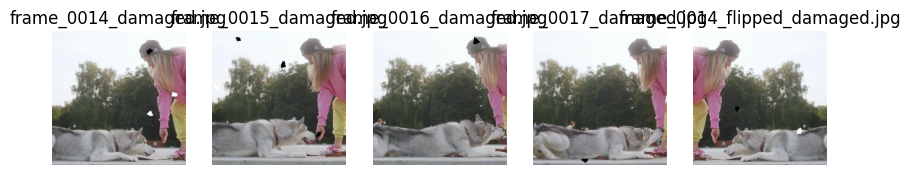

In [0]:
display_image_content(noise_df_damaged)

In [0]:
noisy_df_final = noisy_df_transposed.union(noise_df_damaged)
noisy_df_final.write.mode('overwrite').format('parquet').save(f"{mount_path}/images_noisy_final")

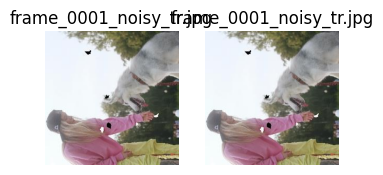

In [0]:
display_image_content(noisy_df_final.limit(2))

# Normal data VS Abnormal data = 800 : 200

In [0]:
display(noisy_df_final.limit(2))

name path label image frame_0001_noisy_tr.jpg n/a noisy List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABTl0lEQVR4XtS7d1CjZ77n23/cOnvu3RvOrVu1tbW1Z2Zsdzc55xw60E1Dk7MIQhISSEICSSAkJBACJCEJ5ZxzRAKRQ+fs3B7b4zzO2e5uMg207yOw2+0wnjk755zd0/Wtpx7e99Vr3g/fX3rBRzYe7W8+2t/a39/Zf7T/6LtH33239913Dx99B77c3ts/1M7e7sO9nYd7Dx/ugYPfbe0+2t17tLX24KuPPvzinfc+/uOf3rj27DvXX3p19ubLviuvTVy9InFP0uQe4vhk15gXzXS3D5haSOPFUH5xkw3ZK6tDKWrR6jq8E07XVnU74QMmGNXWNmhqHVDWkSc6+Q7ksPoc2lRFmekVibEIyWij1og0mNvkyiatCWWwdvp8A15H/6SHZrPgjQb0/DzT5uiemR9aXGItzQ/bbDCXu21peXAq0K/QtEwFyEpVs9dPUulaAwv9rkmiPzA4MdUrlJdoTRCpHAWpO1dfW11RUV5dXVlWVlJbWw2DQVtamlrg0IbG+nZUG7S5qaWhoRXSeORJWHv73wFeuz8ldShwQXCzv7/1cPfh/v6D+w8+eevtL9/+83vP3X1l6dprizfuuOZf811+0TI3z9L6qSJP95gDPeJqZ9rbBiytFFNLr7GFIK9GyapRQ6eqhgvqxBUoQ3OPvrlXXIkxtPTZkQw7kqmB9NnbRrxo7lhes7KM5MSMyjqQXFKlQYFyGjGCsUqdrk1vwfim+r0TFKed4LB2TXjIszMMn5/q9VFcrh67FavT10/P4J1u3GSAItc0GA0IrabV6yNyBZW+GbLT1z0RvJgklpfJlNUGQzcSVtbaDBCVVFeer64srqooaqivqK0631xXjmisaa4qhVaXdcFbqNj2n8ACfgHaCdrnJ6Q2979b3/9uc++7bXBqZ+f+/W8/e/+DL157+53rL7y+dOOliZXn7QtvTl57UTu5NKr29/KdGKYVQTe19JlaKIbmPnU9QV3fJatGy2s6ZNXtonL46NkGam45txwubcSzSuC6RoCyz4EcBBdbYQwbfJh5stmLBvdhjzc09ZZli4h1Fg5Sy2nWimEmE8bpJZpdWLeHOOHs8XnIdgveCmTFu90kow7hdCI83na9ATE9R9WbW8SiKqsF5fV2cfnldnenw4u32/FOZ6dcWa1Q1DntfYMUGLkb2dneikG2gBXeVAOFVHWj4WhoLbqldpCEGe7FDRLQA90dvwrrJ6QOYD1aA3EXJLX7zedffvrOu+8899IbK7dfm71+13vxVfelV6zLKzyrnyzwErh2NNPaNmCF051tgxNYtgfDCn7ZRre20SwIig1JNUKJ8jrMWGlLb04x5VQFIfP82Fm4sqbTDO2xI/qtrQPySpKmherrkjjaR4cLq6gFJ+glhcO1xaOtJcK+Bouy0+siuSe6/b4eu6HTZsBajFiLqdPj6nE5iVZzx8QEVqlsAOCmZ+laYxOPW+xyoJ3ODh6/xOFGm+1Io6HNYmqzmhEKaYPLRh4ZgJKwjWQcqgfb1t0OJXS04pEtOGQzGtEAbSirrThbWXa6obYYUnf+b4K1tf9o69Gjjc3trz754qNX337rxouvL9+6O3Xltn3hqmZqhmUMMLTTA1pXN3+yT7LI0F4aMV4eMV1nW5cHNJNEgQkxYITTtFCytK5TUo0WVrTR8ypw8fm9GWcpucV9mcWjJ5sHsytYp6s1dVhNLVFR2ePu4tuQHFPzIOdMnagSIq6GKSAYEQTBhFSPYCo9GpJa2CTh1hiVSKsO47R0eZykwCTN5+2bnqTq9TCHDe920WZmmXoTbGz0rNOGBGgEglKbA2U0t2qUjQ4zymPHygT1g+Ti4pN/qDgbVZB1VMbtVgt760qSoTXZ5/LDWxsLGutOJCX8c3zcf2tqOcMYQv9NsHb297Z2tr/67PM/333zzSsvvLFw+wXPhZu2hUu6qXmB46LQc1XouyOdviOfuSacmGUY/FSVmyix48ddOJ4Lw3ZiWEYYTd3Ua0RQjbA+A5SkasBKKuGC841DOcVD2aWqSjzvTONgdlFvwumRXIilieFAs61wlrqqV1GO0tR1aBoIBsiAsXVA1IxmwyH87rrx3vLBrpNs+nmzut1t6QK8dKo2mwnvspGs5s7JicHJCdb0NNvhxvM557TKOocVIRKWWi1wg6FZr2p0GNqmnN1mJfLy3JhZjrs8y7mxwnnrrn5pamDOR72+wrl1YfzVW4bnryiXAuzFac7d583vvOk7AjA91vaBnjxyKFAIH3x176PX3n115dnX5p592XfzBdf1u75bL7mvP2+5eFM1e4Hvnh81TdKV3j6xk8BzdHOsnSM27JAVOQDKnBUxYIHTjFAQgBRlHU5S2c4vbuWcgdAySlgna/WQLk0dXl4K552oHEw8M5pRqa/EG2vwyhK0phxnhfRam/pMTf3mZq6lgz0O65B0dYx3tgy1FHZXpRIbs/rgOePUsnF62RCxYKSnkEk86zEQ5iaGp72jM5OcmcCokFckE5XZjDCVqG7CiPWq0frRJiW91sZDLhop79zQX3QOXvT2LnjQt5aY1+ZYL1+XvnRL9NptyTvXlC9fELx4RfTiDemN5bElH/0nsP6Sdrb3Pnv3k1cuPffqwp0XJ67dsV26ab5wRTU9z3NMMnVemsJNFjkIPDueY8ONWrHDNgzDjKToYSRNQ5eiGisqQY4Xw7mFUPbppqG8moHsSnp2BTO/VgfptsEpWki3sgarqkCKCxrGMsu4mZWCE42iExBeTu1Ydp38XLujiepsGbDBOAYUTdGJkXajJDjUKKSMUp7fW5VDrEklt6SyCKe5lHPj9POjxFOD+LzejiwaoYDDrBlnN6hl1TplnUXfohHXihhFnbUhuMoIxLmjbUVHCQ0x3ZBoQlM0ozOXjMwdxJZXn4zrbCpsKk/pa8w2QXON7SdVuNOW4VrrGETDrPybYG1ubL314mvPzl17cerGTcvKVd38BcXkIt82xVS7+wROIteOH7WgGeaOIQMC5KZeZUO3vKZTVI4SFEEF51rGC5t5BRDOqfqR3KrRk3Xss80KkM5hfVYQldBeDSRYK431OHlRi/BErfAERHEOqS1CqQsRstOt4hMtsgKEo77PiWCoYRhVJ0KMbZVjUBJ4iwhWN9xQSK5OH+nIVwxXKMaqlbxqHbdaw61U82vUgjq1qEEprNfLa3XKWoOmQSursirrAya4VwWVDZ+Xj5RIRooko0UKbomUXSpkVgwRiwe6SjjUet5gg4JePdVb6iYXa8hntKwKg7hBPl71W7A29/aAwOb+t/deuHTz+dnrt52Xr2jnV+T+iRGtmypy9Y07CGwrjmlC9WtbScpGoqwOL63plFRhFDU4RTVOUNTKP9PELWjkFkAAMnkZUgchGFrIZhjF1EoBa5AUhKhr7jU396hKEdIzTapipKma4KzrtVURzOU4YylWXYhSnEGoylGqFqgEWUOrOUOvLhkoLx6qOitB13I7zlnGoEZho1bSqBbXGcU1Gn6ZQVKtl1Qb5XV6aY1WUq2UVCplFVpluVlT6dJVmxWVCv45lfC8UlQiGT+nlJQoxIV2U40OdF78Igm3UC0u0SuqdPI6tbRGIiwXisrU+kaDFfZbsA55gfWLzz67Nrt4y3/phuXiBfm0d0Rv7hOYCBwDbtiAGdIiqVo4WdNKkkLw4nqspK5TWotTNRBVDSRJJWasECou7wD9J0BjgVEM0D59K

In [0]:
from tqdm import tqdm

transpose_types = ['horizontal', 'vertical', 'rotate_90', 'rotate_180', 'rotate_270']
num_dog = df.filter(col('label') == 'dog').count()

num_normal = 800
num_rep = int(num_normal / num_dog)

dfs = []
cnt_chunks = 0
for i in tqdm(range(num_rep), total=num_rep, desc='Processing...'):
    df_dog = (
        df.filter(col('label') == 'dog')
        .withColumn("image", transpose_image_udf("image").alias('image', metadata=image_meta))
        .withColumn("name", regexp_replace(col('name'),'.jpg',f'_tr{i}.jpg'))
        .withColumn('label',lit(1))
    )
    dfs.append(df_dog)

    if (i % 4 == 0):
        if dfs:
            cnt_chunks += 1
            df_dog_chunk = reduce(DataFrame.unionAll, dfs)
            mode = 'overwrite' if cnt_chunks == 1 else 'append'
            df_dog_chunk.write.mode(mode).format('parquet').save(f"{mount_path}/images_dog_final")
            dfs = []
    
# df_dog_final = reduce(DataFrame.unionAll, dfs)
# display(df_dog_final.limit(10))

Processing...: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


In [0]:
df_temp = spark.read.format('parquet').load(f"{mount_path}/images_dog_final")
df_temp.filter(col('label') == 1).count()

756

In [0]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def tranpose_images(i):
    return (
        df.filter(col('label') == 'dog')
        .withColumns(
            {
                "image": transpose_image_udf("image").alias('image', metadata=image_meta),
                "name": regexp_replace(col('name'),'.jpg',f'_tr{i}.jpg'),
                "label":lit(1)
            }
        )

    )
dfs=[]
count_chunks = 0


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(tranpose_images, i) for i in range(num_rep)]

    for i, future in enumerate(tqdm(as_completed(futures), total=num_rep, desc='Processing...')):
        dfs.append(future.result())
        if (i % 4 == 0):
            if dfs:
                count_chunks += 1
                mode = "overwrite" if count_chunks ==1 else "append"
                df_dog_chunk = reduce(DataFrame.unionAll, dfs)
                df_dog_chunk.write.mode(mode).format('parquet').save(f"{mount_path}/gold_dataset_normal")
                dfs = []

    if dfs:
        df_dog_chunk = reduce(DataFrame.unionAll, dfs)
        df_dog_chunk.write.mode("append").format('parquet').save(f"{mount_path}/gold_dataset_normal")


df_temp = spark.read.format('parquet').load(f"{mount_path}/gold_dataset_normal")
display(df_temp.limit(2))


Processing...: 100%|██████████| 22/22 [00:27<00:00,  1.27s/it]


name path label image frame_0014_tr5.jpg dbfs:/mnt/vision-test/images/frame_0014.jpg 1 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABVBklEQVR4Xry8B3RbZ5alayvY1V1V0/2qe817XbP6zfSULYmZyGDOOeecA0iQIAJBRIJIBEAQAAECBEAQYM45B1E527LLOck5yZJsRYqZkuqdC9iySnZ7qqu73l1n/evyEg741j773+figs8887c+nv2zenbfs88++8y+fc/u27dv//4D+/Yd2A8Fl+Dic/t++0+/ftH59yERrgkpbilp2OycwJzckLyC4OLSUDo1UdFYpddLrnz87rdrd25srH+3vnF7bePu+taTdef+Jqz3NrbXNnfub+0i6+be2sbuvXXk5GcLfnVv48G9jUc/qT/Z69G9zYdrWw/vbz94+q39rY9nfzj22Q/g9fxzz/33//5P//vF/+WKccL6uobFYtJzfHJycLk5hMwMYma6d36uP7kyklWbJhVXTUx0fXv7+s31tev37393//8nWA5S6zsPn34zf+vjWURaSP3zP/+zi4tzSkpyTGwkFu/mgXN2xR7C+ztFxaMKivzLS31LCrwLcokVZcFkUhiTFi/gFehbhRcuHrtx88bNtfvf3l+/tb75N4Zlr00g9XB958HG7t8GFkjmB+3sP3DgwP79yHrw4MHf/va3/+P3/+ri7JGYkJyCHElcHsvHF4/1cnVG/8EF+wLe/3BcMiYvzzsvC1Na6FNFCqqlRtdS4zjMVLWK1W5Rnb9w6rvbt2/dW7+5tn7LzuUpTI9JrW/vOeoXYMF1R/0srLtwcfPB2hbU3n34V+38bdoQSAEgR5c999yv/vVf/2dgYDCbzYXKyy3KzMjLzspPTU0rKS1kcxjuqCPOqBedMC+64F70CXZLTiVmZ+ILcn3IFWHUmsjqqnBaTby4oViuYB09NvvlV1/cubt++97G3fvbd35OU0/K6vv6C2Ct/Qysh3ZSCCaE1O7ext7e0+/zv+QAHf3mN7/5/e9/n5SYrG3Rr6wcP7Z6UtmkriBVpSRnZmbkA7KcnFyxpCE4xNcD7eyMdnIjuGH9PAPCMNEx6NQkTGFRCJWWUEYKzi/0KydFU6mZ/QOmb29evXPv3nc37127DuLaeEznZ2E9rr8S1iZY1QO7VUEBqd3NB38NLNjVoMtAOAcc7gMC+uFHRFDOzs4FBQU6nW5qamppefnU6bPj49NCYWNFRU1ebmlOdnFeTlFxYUlxQQGlpsIT6+yGBWUddse5oL3cUIQjBB+n8ChsRnZATn5QUhouIRmblhFYWZV17NjcjRtff/vt9ddee/3Khx/furN2Z2Pr5vom4lzAaGMbtLa2vrt2f+PuvY3bd9fXNoDOgzWAsrV3b2Pn7gYY0+7aFlLfdyjYNrxg/cEaWPjGw7UNeNne3fsAbg8pQAmqtMMCt9rYfbCx91e2od2RYM8/cAAJAfv3/frXf/9v//ZvOTk5ZrN5cHBwdHQUSM3Pz0/PznTYbHRGXTWFXlxMzssrLygoT0/LTktMoVaRU1LinT1edEIdcvY44uzp5OJ52AV1COPl6hOEiYjCxicSUzP8UtL9k1MCyVV5k2P9s7PjU1Njc3Ozn3/5xb37G7fWN25ubN3a2AJYd9a3765v39/YWVtb/+bqjRvf3l5DpASwgAhi4SCf+5tIfXdnDdR38+79e+vbdi4P7t1/COCA9Z/JbRPB6rAqOyyknsbw7x+OpPT9AXI6cHDfP/5f/83DwyUhMSYiMiQ+IbqmhspisSQSSWOjTKNpaWpSNgjF1RRaaVlFXn5JRmZedk5xVlZ+XGxCSkISo6Yag3Z3RTkdcj/k4uHm7OHq5O7shnZFEzwJPujgEExcgk9ism9isl96RjiJlC0RsfT65uXl2Zdevvjdze8A1m3AtLl9ZwPMa/Puxtbaxta1G9++8847r732xjfXvl1bR948IhDoyo2tdWjJja2PPv38/MWX3/vwoy+uXgM7A17A8dbdjc+/uvH5V9cdvP56WI/T0L5nD+7ffxDOn//V8//Pv/zffv4+qWmJFZUlBYXZ4RFBiUkxhUU5+fkFRUUlFAoVjJzJZPH5AgqFTqqoLidVZecU5OYVAa/Y2ISI8IiivLy4qAhX1yNOboedUa5Obh5Obm5Obq5uKHd3jDsK7xEUgo+JBVj+SSn+WdmRpaXpfG51W1vT2XNHP/7kgzv37t5d24TmspPauvbdzU8+//z02TNj46OnT58EXb/6x9fv3d8EHPBbIHvtxvVr16+dO3+up693ZfXo62+9fef+OhRI8LW33h6bnn7l9bdu3ll3aPBHU/tzUv8HWHZMyPH883//3377u+CgsPDw8Pz8nJLSAlJFSWlZYWZWalx8dEZmakVlaXl5SXl5Jam8ik5j1vNFfL5QLJLx+RKBoLGSTC0prSgqLo1PSA4NDY2KjCCXl2E83F1cnFw8XA67uxxxRUg5u7u6okBizhgCKiAQExPrm5YRnJzqn5UTXkZKZbPLlpZHPv/i3Zu3rq3dX7tzFxLW9s17G6CR9z/86PIrLw8P9/f1dfX2dlss7e++997G1vZ3d+7Bbz/9/OOPPn7/8isXu3tsPb2dk1OjH3/26e21+19+c/XC5UtD40MTsxOffvnlnbUth6y+J/VDXPhLYTnyEQ6Hk0rly0sndNo2Go3GrKNTaeSyctjOcmD7z8vLI5PJVVXV1dBvVGYtg8NhCyRiuaxRKZeppFKkyGR6JbkmPSMrJCw0KCSwuCgvJyPVw8XZxQWU5fyiq/MRNxcXTzfQlCfOA0P0xBI9AwLRqWkhmTkh4PR5hWFVlDRZI62nV3v85Mw777727c3v1u5v3Vnb/ubG7bfe/eDc+fO2zg5Fk1inUwKLS5fOX79xfQ3moTt3371yZXF5trunQ6trttpMx08snzl74ouvv/r6+rW33ntnYHTAbDOOTA1+8PGH0IMb24jB/ZWw7P13sLaOvXL0xMTEnFAkqaisqGXSmXW1VdVVubn5hYXFFZVVNBqDSqXDWlfHhV1PIJAoFGqptKmxUalQ6CRiFZcjrCBVh4dF+nr7QBLl8/kEAt7J+cgRl8Mvuh5+0f0IqMkD64G4lR+W4IfG+3pGxfqmZ4bFJXolpnhnZgeVVyRweKXyJubouK2nzwK2dfXq9Zu37n3x1TeffPrZxUvn1Ro5h0udmR3+4MN3rl7/8vOvP3v5jy9NzEwYzAZzu7azyyQS8wBlX5/t7NkT73945dS5M+MzEzqjtr3TfOr8qa+vXYO+Xt+0WxXiVntP7INI2QPEL+2GsOEd+O0//G5wdGL1xJm+/mFSRUVpeUltHbNeIKbUMAqLSkpKyyk1NBod2NVUU6hcXgO/XiQSy+QKVaNMKW1UyhpbmpUGoUBWXlIZFRYZEhDAoNLS0jMPOzkdcjnyouuhQx6HjqCc3DFuGCIa540h+mO9A3G+wfjoeP+QCHxoBC46zguasbIytag0vrI6g8kmteoVb7/92t27d27fvvPJJ5++9NKFgcHuZpVEKuMMDHdMzoxMz40ZTC3ixnook0XX39/e1CRgsaqFQnaTQtLbYx0cGrJ1dQ+ODBw7ufLGO69/8NGVt95579bttXtrm5DL7kHt7N3f/R7W5t4jBywQ2tOEnjiQ2BQUGjE9vzy7cFTX2padm1tYXEClU2vhf7miurikDGABphoqHZCx2FwOV8DjC4GUokkNq0zeLJe1tGhMjZLm3Oz8YP/A9OSkanKlB8rziPPhI+

In [0]:
display(df.limit(2))

name path label image frame_0014.jpg dbfs:/mnt/vision-test/images/frame_0014.jpg dog List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABSbElEQVR4Xuy8h1ebZ9b26//jfO97JokxHSFUkUTvvVdRVEAIod4FEqIIgUCoIKFekASIjrGxHZcUp/c6k14mmXTHheJe5myh2M7EM3kz57zfOt9Z55tc6143khA8P137uvd+zJpDV/bv/ka71+/sXr/9B3Rr78bt/Zt3/oiu3rob1f7tu3t/QNfu3PlXun737v9bOvSA0c7Ve1H9b1j/Sg9h7V77+y/637D+hQ49MNQfdNbOtVtRAayoHkXzO9q7dWf3vh5l9EBXb9+O6n8FRg/0b8N6ILBVVI8S+R39/wvW3o07UT0K4o/o/+Ow9m/v7N8C7V69HdXetVt716O6vX8jogcm+nd99Gv9klm3fvXgrd/qQbQ90DXIr9v3IrrzS5A9eg3X7kV0Fda7d6/evHPj9t2ffr703fc/X7y0+9VX33399TcXLly8eevOrTt34akbsN49WH+lB2/yQPDIzTu/6Nade1Ed2r1664H2rgGp27vXbkYFvKKwfs3rUQp/RL++/kef/acvuw/rgNTvw7obIRWFBTi++/6nzY3jwcCix+W3WZz2WYfP4z+2dfyjjz65fvPWjdt3fkMqCuuXd4joHuj6vXs37/39F929F9WhKCDQ/vU7UYGhos56QOp/cVgPdfvO13/7bmFx2Wn3mI2WGcOMQWec0k5OjU9ZzbOh0MKrr71x89bt67ce4XX/HW4Ao7//PSrY/0b/AOvqjbsRwS/9j/p/DusP6o/AeqCrdyOCDVzqtZu3Lu/snj//vNPlMZstE1rd2PDYqGp4dHBkTD06NqSZ0Iwb9MbNja2Ll6782lwPXAO6DhaDRw489QDfzX8bFgTz/3xS+/8+rP0DWEDqys7u0Y0ts8E8rdePjY6pB1RKuUIplQ9KFSpJv0o2MDSgBmTWmdn33vvz1es3Duj8itSde7fv3rtz9++3bt+9eTsaUndvHWzgS3gKFMmsB7Ae6OqN38KK6L+qoP8W/Vuw9u/DunH79jNPPztrsk6N6bSascEBpUIilfKFUi5fxhXIeWI5XzIgUaj7BzVDGr9v7ocfLwCgW2CW+86Kkrp2/eaVnb2r127cuHkb1r2dvZ3LO5d/vnzl0g5sdq/sHtq9dvdAdw4U2USS60ZEB9Tu/qL7v/3vXNijehTH76N5oIND8L4imP6B1MNch/2dO99+973P7dVrJ8aHR4eUarlYJuGLxFyhkM0XsHhcFk/AEasUw/3SQaVCpdPqNo8e++GnCzdv3/nFVvcirtnb3fvis0/ff/uND0BvvvHOiy+/ff6VD155+5M3//zFnz/52ydffvnhZ/+kz9q7dueRwvwnF//oFT6qRwH9wXf4jYkeJXWge5FHbt06e+7cjMEwNqQeUSn7JQoRV8Tv4/FYXA6TzWL0MZkcnc40qbPotMZ+ycCwcnBCq11fXb92Dc6DO7cixXgX9q+++OLpYxsn1xaeWg8/vbr07PL6S2tnXz/+3HvnXv34pfe/evfz7z74+vdgPdT1B43o3Qd69Ar/qR7W0YGu/jFvPsroUVhRu13c2XG73XqdDmCp+xXgKW4vh9Xdy+zq6aF1d1O6uroYatWoeXrW7wqqZEqFSDg6OGia0s95vaFgIBgMeP1et9NpmZ4O2K1L7tllh2XNbjvtDz87f+q5xTPnw2deWH36je2Xvnzlk38Ca/dfw9q78d8G69FX/sN3PcLoUV4RWLfvXNnbnwsEpibGx9TqAalYxONzelnMru5uKq2LQgXRKJRh5ZCYK+6j97Jp3Xxmt4LPlXE5AyKBXMiTifhSMV8m4CmFAp1KYRkd9E5ow9OmLatnezZ42hU+H9x8fuHYi+HtNzfPHXpws+EhrEgf/7BHjcLavX43qr0b9w70X5TYHyHyEM0/Aj2I898CelTXD2BBH/D2229bTMbJMY1SJhZyuZze3h46vZtKpba3U9rIVHJrV1sHo50qZPYpgBGvDyRhdgu6aXwGnddD6+vqFPZ2S5iMfhZjXMSzq9X+4fF5zfTyhGF9amZl3LCinT5pdr40t/TPnPUorEjwR5ne+0URav8wBv3TxuJRLv9UvyX1x2BdvRWZHOFEu3T5ksfpsM/MDCqkQi6H08vsoYOtOoFUJ7m1u50s53KHJPJBoXhMLlXxegc5zGE+W8FiSJg0flcHq7NFxKQLaJ1iWscQi6Hj8GaE/Rb+oFsyFhyYWh4yb47ZtidcZ6b9D+9nXbl6L6qdq3cezIn3T8l7v3HfDjx4/xbNI/dqHpjut1D+lX5L6o/BivACf92+fev27TmP12aeGYF857D4zC42ndLT2cbt7ZIJ2AoOSyOXWcbHRySSSWX/mFSg7Ose4vXq5MJhIVvSQxXS20EDfQxuS6OkpW2E2qtniL2SySW1+/h48PjY3Mag69RY8Lxx7dClq3d/o0dvND/qvp2rd38zUe5FhspIwR60HQe59kvn8U/6tX+lfwvWwz7r1p2nzj4NfZZJO66TCXUSvk7MH2QzBjiMqWG5Xi4dFfCMI2rj2PCEUmHVjqrY3co+unFQqh8QKXqp8p5OIbVZJ+KqOuhTdJGbM7o6YFlXOzZGfZvDzgWRLsAdXZRMndYFDl3cvxPVfwOs+3voOa7dvBfpPH5D6r8V1oMO/vqt2z/88NNbr78VdLgD+kmPZtQ+qJyWi0aELOe0xjsxphXzh8U8x/TEjHbYo58AWCp2F8CyaweH+cz+XqqY3mpSiCd7uSaGzNo1EODrVgasyypHWGYMcEaC3JEAV7Ohmj30897tqB7AuvxHYf022nZ2r124uLO3f/PiJeiDb129FpnAfwvrd3n934MVuW1w8xbMMO++/uaqzRHUTdmUKoNEpBGwHBPqTeesSaUYErDNWrVLrw2YpzTCPhWLbhgQO7TqCQlX3t0h62qbFHIsQtkMQ+5gDM7SlT7OeFBkCPEnvD1KX8+Av1e92W9+6KwHegDrEUAPdWU/0l7s7N+MwoJ1Z//GN99++9HHH3/517++9/77P/z4w/7Vq5d3r+5eu3ntVmQUfwDrj8T/o2ge1dX7m+uR5Lpz7fbtq1evv/7s8yfmF2fVQ3qRYELANg2IVi3G4PTEsLDPYxj3GyfCs0YANNjXpVcI3RPDsAdwMjp5UsCxCmQz3fIAR+vsGpylDvjY2rm+EQ9d6qaKvV2KNan+98rwUUYPBIPRpZ1rP13chfXny/s//rzz6Rdfnz174qmnT54+c/zpZ5586eVnvvr6048+/fRv3/90cWf/187674L1Dzq4e7d/+zaU5P6VnWePbllV/XalbFYhnFGIN13WaaU4MDNp16pDpkm9XNDP6JwZlDk0qgkxR9VLk9PJRjHfypOaaOIQb2KeOwG83IyhOaba1SF0tfFcnaIVvvYhrMvX7kV15T6vRxn9Cta9H3/efffPH33yxVevvvEObP7y0aeLS97wsmfjaOjoVmjzaPDY9uILLz3//gcfff7VN/8znPVrUjs3b/y4u/Pj/t7FW7ev3rjx6XvvOUaGbXLJrJg7LWCv24wu3dC8bdo2pvJPaWbVikEmzaKUOkaU5gFJf1dHP71Nz2NbuZKJlr4QR7sqNjioSgdtYI6hdLZyrQ09DjJvmTv2q9bhvi79ymsPCP5GVwDWxZ3F1XBw0eX2WY4d33znnXe3t9cDAdv8/KzXPbG0aFpa0J87t3buqRMff/zJ

In [0]:

num_noisy = noisy_df_final.count()
num_abnormal = 200
num_iter = int(num_abnormal / num_noisy)

print("num_iter :", num_iter)


def tranpose_images_noise(i):
    return(
        noisy_df_final.withColumns(
            {
                "image" : transpose_image_udf("image").alias('image', metadata=image_meta),
                "name": regexp_replace(col('name'),'.jpg',f'_tr{i}.jpg'),
                "label":lit(0)
            }
        )
    )

dfs=[]
count_chunks = 0

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(tranpose_images_noise, i) for i in range(num_iter)]

    for i, future in enumerate(tqdm(as_completed(futures), total=num_iter, desc='Processing...')):
        dfs.append(future.result())
        if (i % 10 == 0):
            if dfs:
                count_chunks += 1
                mode = "overwrite" if count_chunks ==1 else "append"
                df_noise_chunk = reduce(DataFrame.unionAll, dfs)
                df_noise_chunk.write.mode(mode).format('parquet').save(f"{mount_path}/gold_dataset_abnormal")
                dfs = []
    
    if dfs:
        df_noise_chunk = reduce(DataFrame.unionAll, dfs)
        df_noise_chunk.write.mode("append").format('parquet').save(f"{mount_path}/gold_dataset_abnormal")
        


num_iter : 3


Processing...: 100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


In [0]:
df_normal = spark.read.format('parquet').load(f"{mount_path}/gold_dataset_normal")
df_abnormal = spark.read.format('parquet').load(f"{mount_path}/gold_dataset_abnormal")

print('normal data : ', df_normal.count())
print('abnormal data : ', df_abnormal.count())


normal data :  792
abnormal data :  168


In [0]:
df_temp = spark.read.format('parquet').load(f"{mount_path}/gold_dataset_abnormal")
display(df_temp.limit(2))

name path label image frame_0014_damaged_tr0.jpg n/a 0 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABS00lEQVR4XpS5Z1SjaZbnyezZ2TPdp+fLfJmzO921lRlB4OUdMiBAeO+NQMiAEEJCBlmsBMKDHCDvJRDCexdA2IyIjHRVlVVd1VVZJrNsp8+IzIzMyurdvYLqrHHd00vc85xHr16Z9/f+7//eq0gIRTch/OG10MrG8tpOaGUTNoHw2sb20frWYWh5IxLdWl3fC0bW/aEYbDZ3jrf3Tnf3b+/snGxtHa2v729uHm5sHOzsHm/vHG5u7W1t769E150un8m8GAitbu0cxzb2V2I7K6vbG3D+xt7G+i7E5sbe1uZ+PLb2Yxvba5s761u7ENt7hxA7B7d3D872D852d44Odo4Pdo7gzbd2Dtc29za3D3YPTrd2D3f3Tg4Pz/f2Ts/O7u3vn+3vnx4enJ0enx8fnu7vHu3vHsJ6cnT7+Oj22enl6enF6cnFyfHt05NziLPTi/Pbd26fQVzejm/unp5cnh5dnB5dnh3dhTg9unN0eHtv/2T/4HRv7/jo4GR/Zzfh5Pa947N7ZxcPjuEF5/fh4e3Lh7CeXTyEg7cvX7k+CAEbOPLnOL9/fv7g4uIhrBC3b98/v3hwcXn/DD74/O6duw8v7zyAuLh4cHnx8PL84cV5fHPn4pWLi/uXF3cvLu5AXF7eu3Pn3uXl3fOLOxAXl3chLu/ci+/v3r99cffsNlzS5cXZ5cUJXPDtk+Ozs9Pzq9fePT+/c3F+5/z8Ek44Pb0NB+EI7M/PLiDOTm5fb+5e3rt//+G3ce/eg+vNgwevQFzvHz589ODR4/tPntx7/PjeK4/uP3x8597DO/cfnsN3uHv34t79s8u7Z5d3Lu/fTwiEVsKRWHg5FgxHI8try9H18PJaeGU9GIlBBMKrvuAKhDewDAEbfygKEQhFg6FoKLwagKd8YQi3J2h3eCxWGwhqYdEBAQ+XrI4Fk82x6F40221W56LJZrUsms2m65ibm52dnTFbzAsLixCLS0vXAX/WBdPiksVmW3DYloxzc0sLVtPcrH54qE8qUcrlg1qtVqmcnhjf2ojtbm2AhHa3Nw/2tne3NndB2Du7sD3c2z8+OLy8fX4O3E6Acjxgf/sUuJ9dr3D85Pjk+Oj44Ojo4PTw8OTg8Gjv6HB3f2fzaG/7YC++2d/e2Flfi63ClYYTFEqVTN4nFIm7hT09ol6RWCLslXaLpZ3dom6RVCxTyFXaPnU/BGykCrVSO6gd0o2Mjo8Zpgzj0zr9uH50YnBIL+9Td3R2N7ew6uqbJ6fmgvF7sBoOLId9kfWVjZVQFDbxCIb9fq/dvmQ0zo2N6XW6YZVS0dsrZrW1NTQ0VFZWlpWVNTU1tjRVM5tqhF1cRZ+ki98hEYslIhG7lSkWdgc87vnpqZGB/q3Yyv2LE4/dOm0Ynp8ahZg26Cb0o6ODw5P6sdnxSePUjHNhKeQPbG0Ayr2jg8O9nd2dTUj1nZ2trc31jbXV2ObaOmy2YrHN5ch6wD/YK+5paVRx2we7OnQ9PVNSyYysd7iLL2Pz1EJpgrxPqlTKhfC9uO1NTQ0tzCZuZ4ekDxipZUpVn1ozqNOPTU5NzMxOzxshZoymeYvVDFpYtNnsTojFJbvRZJmcmhkaHpXJVd3C3qnp+fWNnY3N3e3tvb3dg/29w62tna3NeOzs7B3A/YObeXC0trYRiSz7fD6P2+mwL5lN84MDWmF3l0wqFnBb2xprRvrV43q9YXTcbnP6fYFIeHl/7+Dhg1d2tuFNDx8/uP/4zpm4k51HIWQRMNlEDA1WEqmmtKyby53S6x0WS8Dl2tlYPznYPz85Pt7f21iNBr2esN/nczntC9YrnZvG9Tp5d8+4Srs0Oi6oqW3LzW2mZDYQ8CwajUencqgEZiahjkwLm5wJHZ3sXomwTyGRycXCHr5ILJDIZUP6UZ1hXD8+YZiavsY0Z7YAI9PCIoRlyQYBmOwOl9PlgRXAzRvNE5Oz/QMjfQoNiG5n9/D45HzvAKrETmx9c2NrZ3N7F9bt7f24Xx6egaGenFyA9R4fne7Bjd5YW19diQT9LsfS7NT4xHD/2IB6NRRaCUaWw7GD/bOjYzCo+3fvP3rl8Wu3z+89fOXpw7v3dqMr3OZGAattVKM29Gu9i9aD9fXj7a3zg/37p6cPzs7unhxfnh7fPQcnP71eIS5Oj799eLi77XXaXYs294LdZ1kclcgFNdVaNkvWUNuely0sonOzcGx6ZkdFZdQZSOjsYHV1caQy0dDwgEqtkUI6aftH9GO6UcPgsE47MNQ/ONw/MDw0MqofmxjRGwwT03NGiwluiWXBZLZarPENKAv2syarYWp2cmZ+zmRdBUj7R7BG1+IRF9rG1sb6BlSog92zo8OLo6OL/aPzw9M7RyeXx4dnEIf7x1vr4ELr4J0gh2Mob0fHp0enUNHu3Xl4eXHvlYePHj185f7de/euHP7y7PT06Oj8BOLw8uToztnx+dFB1OdZmp2ZM4wGXY7750Dk9PICqsB5vFJcFYW78bJyLx7g/WDhp7c31jZWV9eXFl2zw1NLunm7wewAk5ycHeCyO/NzW3CYFhy2lUwebGcndHexOztZbE6rUCjolci7usUCoQicSyZXfBsSaR8wVKkHrgPkMz4xA3k3MTkNYRif1I8a4CHAWnS4l5wepzcQiACi3bWt/bXN/dj6TmQ5Fo2urcFu6+Bg7+z46PLi8tHdB69ePnj14v6TO/eeXNx5BfRycX4PSt7x8cnp8fHZyen52W2ojvfvPjg5Oo0EA9a52UXjvNMy710wB+3WiNd5uLu1thLyOZegjsyO6yd1Q+MDg52tbU1V1aymJuP0NEgXKt89gHPnzt27gBmK4/0H9x9BBkPcu/sKBLQUlxf3T4/O96J7G67Y2lL0KHjgHbM6e1UcYrYwp0hZVjvDEUSHDAkiIbettaGxsYbFauVwOzkdXR18ATh9L+DqUwIp2AMspap/YFAHdj48MgYBpj5mmABAU9Ozs3NGkNXcPJRB+4LdZVqwzZkXAFlkdT22dbC5d7KxfRhb345AeQ1GNtZ3jo8voIF49Pj1J0/fevX17z+GeCMeT15/6/Grrz14CO0FJMrJ5fnFwf6+w2YbHxvTDQ+NDWnHhzTTugGTYcg6MWKb1tvmDItz45PDmml9v3FCZ5keM02ODSvVVUUlKqnMvrAA5dbndoM/AqI/U7r/4MEDaBce3b/35wBY8fXy4St3H925DSb49Mnu/Ye+o3WFyV4v9PBV5xZ/eHBmktlzMGZL4PNaq6qK6xuq2WwWl8cHWPwuIZCSyvq+VdbA4AjUO4gRneEK09ToGJQd2BtAVjOz89aFJbCwa1LzlsXpebN+fMrh8UOXu3N4sXt4vr1/sraxCyVydW3r/A585ycPHj45Ob0MRVYdnoDV7bW6PJHYOpQmn9e7urKyElmxmi1DA/0atUKrUfRr+0YHFKMa2axOM6/XzA4rjDqVfXrEbZpwzI+5zFNOy6zDMjsxMtTF5honZ6KhSNDrc9jsoWBoYWHJ4XBBP/XKK4//HA+fPHrlKcQrD199/Og1WF9/8ubTR68/fPzawwev7ge2DqeDW71z6zzdVt+sT2bYm3buj9sPdAsJUKQLC+lMZoNAwO8RSQTC3i5BD2hKqdIAJrWmv39g6FtYIC4gBfoCakPDuhHd6PjEFGgKnAs83u72QRqCviBAXIN6g80bCcX2tw8vtvZPN3ePoP+G3Nw9PDo8OT